In [388]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


AIm:
Clean survey dataset
- unify commata to decimals
- clean columns from typos
- define correct datatype to the columns
- select columns which could be later needed for model development
- combine targets based on compared damage variables and flood times


For reasons of reusability and comparability the workflow of the data preprocessing was kept similar to previous preprocessings of the same questionnaire. This was achieved by dealing with missing or erroneous values in a similar way likewise erroneous values with commas or points in the beginning were converted to decimal numbers beginning with zero. 

In [389]:
import sys, os

import numpy as np
import pandas as pd
import geopandas as gpd
import re

from itertools import compress
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

import matplotlib.pyplot as plt

sys.path.insert(0, "../")
import utils.utils_figures as f
from utils.utils_processing import drop_object_columns, drop_typos
import utils.utils_feature_selection as fs

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)


In [390]:
# load raw survey data

#raw_data = pd.read_excel("../../input_survey_data/all-attributes_shophouses.xlsx")#, thousands=',')
raw_data = pd.read_excel("../input_survey_data/raw_data_vietnamese_geolocations_no_dublicates.xlsx") # Niveditas dataset with vietnamese addresses and improved geolocations and building information from Tuebingen
raw_data.tail(3)                                 

,id_x,Q0.1,Q0.2.Ward,Q0.2.District,Q0.3,Q0.4,Q0.5,Q0.6,Q0.7,Pre.Q1,Pre.Q2,P1Q1,P1Q1.specify,P1Q2.1.1,P1Q2.2.1,P1Q2.3.1,P1Q2.4.1,P1Q2.5.1.0,P1Q2.5.1.1,P1Q2.5.1.2,P1Q2.5.1.3,P1Q2.5.1.4,P1Q2.5.1.88,P1Q2.5.1.99,P1Q2.5.1.specify,P1Q2.6.1,P1Q2.7.1.1,P1Q2.7.1.2,P1Q2.7.1.3,P1Q2.7.1.88,P1Q2.7.1.99,P1Q2.7.1.specify,P1Q2.8.1.1,P1Q2.8.1.2,P1Q2.8.1.3,P1Q2.8.1.4,P1Q2.8.1.5,P1Q2.8.1.6,P1Q2.8.1.7,P1Q2.8.1.8,P1Q2.8.1.9,P1Q2.8.1.10,P1Q2.8.1.99,P1Q2.8.1.specify,P1Q2.9.1,P1Q2.10.1.1,P1Q2.10.1.2,P1Q2.10.1.3,P1Q2.10.1.4,P1Q2.10.1.5,P1Q2.10.1.6,P1Q2.10.1.7,P1Q2.10.1.8,P1Q2.10.1.9,P1Q2.10.1.88,P1Q2.10.1.99,P1Q2.10.1.specify,P1Q2.11.1.1,P1Q2.11.1.2,P1Q2.11.1.3,P1Q2.11.1.4,P1Q2.11.1.5,P1Q2.11.1.6,P1Q2.11.1.7,P1Q2.11.1.8,P1Q2.11.1.9,P1Q2.11.1.88,P1Q2.11.1.99,P1Q2.11.1.specify,P1Q3.2.1,P1Q3.3.1,P1Q3.4.1,P1Q3.5.1,P1Q3.6.1,P1Q3.7.1,P1Q3.88.1,P1Q3.88.1.specify,P1Q3.8.1,P1Q3.9.1.man,P1Q3.9.1.days,P1Q3.10.1.1,P1Q3.10.1.2,P1Q3.10.1.3,P1Q3.10.1.4,P1Q3.10.1.5,P1Q3.10.1.6,P1Q3.10.1.88,P1Q3.10.1.99,P1Q3.10.1.specify,P1Q3.11.1,P1Q4.2.1,P1Q4.3.1,P1Q4.4.1,P1Q4.5.1,P1Q4.88.1,P1Q4.88.1.specify,P1Q4.6.1,P1Q5.2.1,P1Q5.3.1,P1Q5.4.1,P1Q5.5.1,P1Q5.88.1,P1Q5.88.1.specify,P1Q5.6.1,P1Q5.7.1,P1Q5.8.1,P1Q5.9.1,P1Q6.2.1.1.relationship,P1Q6.2.1.1.specify,P1Q6.2.1.1.Se,P1Q6.2.1.1.Age,P1Q6.3.1.1.Rank1,P1Q6.3.1.1.Rank2,P1Q6.3.1.1.Rank3,P1Q6.3.1.1.Rank4,P1Q6.3.1.1.Rank5,P1Q6.3.1.1.Rank88,P1Q6.3.1.1.specify,P1Q6.4.1.1,P1Q6.2.1.2.relationship,P1Q6.2.1.2.specify,P1Q6.2.1.2.Se,P1Q6.2.1.2.Age,P1Q6.3.1.2.Rank1,P1Q6.3.1.2.Rank2,P1Q6.3.1.2.Rank3,P1Q6.3.1.2.Rank4,P1Q6.3.1.2.Rank5,P1Q6.3.1.2.Rank88,P1Q6.3.1.2.specify,P1Q6.4.1.2,P1Q6.2.1.3.relationship,P1Q6.2.1.3.specify,P1Q6.2.1.3.Se,P1Q6.2.1.3.Age,P1Q6.3.1.3.Rank1,P1Q6.3.1.3.Rank2,P1Q6.3.1.3.Rank3,P1Q6.3.1.3.Rank4,P1Q6.3.1.3.Rank5,P1Q6.3.1.3.Rank88,P1Q6.3.1.3.specify,P1Q6.4.1.3,P1Q7.2.1.1,P1Q7.2.1.2,P1Q7.2.1.3,P1Q7.2.1.4,P1Q7.2.1.5,P1Q7.2.1.88,P1Q7.2.1.98,P1Q7.2.1.99,P1Q7.2.1.specify,P1Q7.3.1.1,P1Q7.3.1.2,P1Q7.3.1.3,P1Q7.3.1.4,P1Q7.3.1.5,P1Q7.3.1.6,P1Q7.3.1.88,P1Q7.3.1.98,P1Q7.3.1.99,P1Q7.3.1.specify,P1Q2.1.2,P1Q2.2.2,P1Q2.3.2,P1Q2.4.2,P1Q2.5.2.0,P1Q2.5.2.1,P1Q2.5.2.2,P1Q2.5.2.3,P1Q2.5.2.4,P1Q2.5.2.88,P1Q2.5.2.99,P1Q2.5.2.specify,P1Q2.6.2,P1Q2.7.2.1,P1Q2.7.2.2,P1Q2.7.2.3,P1Q2.7.2.88,P1Q2.7.2.99,P1Q2.7.2.specify,P1Q2.8.2.1,P1Q2.8.2.2,P1Q2.8.2.3,P1Q2.8.2.4,P1Q2.8.2.5,P1Q2.8.2.6,P1Q2.8.2.7,P1Q2.8.2.8,P1Q2.8.2.9,P1Q2.8.2.10,P1Q2.8.2.99,P1Q2.8.2.specify,P1Q2.9.2,P1Q2.10.2.1,P1Q2.10.2.2,P1Q2.10.2.3,P1Q2.10.2.4,P1Q2.10.2.5,P1Q2.10.2.6,P1Q2.10.2.7,P1Q2.10.2.8,P1Q2.10.2.9,P1Q2.10.2.88,P1Q2.10.2.99,P1Q2.10.2.specify,P1Q2.11.2.1,P1Q2.11.2.2,P1Q2.11.2.3,P1Q2.11.2.4,P1Q2.11.2.5,P1Q2.11.2.6,P1Q2.11.2.7,P1Q2.11.2.8,P1Q2.11.2.9,P1Q2.11.2.88,P1Q2.11.2.99,P1Q2.11.2.specify,P1Q3.2.2,P1Q3.3.2,P1Q3.4.2,P1Q3.5.2,P1Q3.6.2,P1Q3.7.2,P1Q3.88.2,P1Q3.88.2.specify,P1Q3.8.2,P1Q3.9.2.man,P1Q3.9.2.days,P1Q3.10.2.1,P1Q3.10.2.2,P1Q3.10.2.3,P1Q3.10.2.4,P1Q3.10.2.5,P1Q3.10.2.6,P1Q3.10.2.88,P1Q3.10.2.99,P1Q3.10.2.specify,P1Q3.11.2,P1Q4.2.2,P1Q4.3.2,P1Q4.4.2,P1Q4.5.2,P1Q4.88.2,P1Q4.88.2.specify,P1Q4.6.2,P1Q5.2.2,P1Q5.3.2,P1Q5.4.2,P1Q5.5.2,P1Q5.88.2,P1Q5.88.2.specify,P1Q5.6.2,P1Q5.7.2,P1Q5.8.2,P1Q5.9.2,P1Q6.2.2.1.relationship,P1Q6.2.2.1.specify,P1Q6.2.2.1.Se,P1Q6.2.2.1.Age,P1Q6.3.2.1.Rank1,P1Q6.3.2.1.Rank2,P1Q6.3.2.1.Rank3,P1Q6.3.2.1.Rank4,P1Q6.3.2.1.Rank5,P1Q6.3.2.1.Rank88,P1Q6.3.2.1.specify,P1Q6.4.2.1,P1Q6.2.2.2.relationship,P1Q6.2.2.2.specify,P1Q6.2.2.2.Se,P1Q6.2.2.2.Age,P1Q6.3.2.2.Rank1,P1Q6.3.2.2.Rank2,P1Q6.3.2.2.Rank3,P1Q6.3.2.2.Rank4,P1Q6.3.2.2.Rank5,P1Q6.3.2.2.Rank88,P1Q6.3.2.2.specify,P1Q6.4.2.2,P1Q6.2.2.3.relationship,P1Q6.2.2.3.specify,P1Q6.2.2.3.Se,P1Q6.2.2.3.Age,P1Q6.3.2.3.Rank1,P1Q6.3.2.3.Rank2,P1Q6.3.2.3.Rank3,P1Q6.3.2.3.Rank4,P1Q6.3.2.3.Rank5,P1Q6.3.2.3.Rank88,P1Q6.3.2.3.specify,P1Q6.4.2.3,P1Q7.2.2.1,P1Q7.2.2.2,P1Q7.2.2.3,P1Q7.2.2.4,P1Q7.2.2.5,P1Q7.2.2.88,P1Q7.2.2.98,P1Q7.2.2.99,P1Q7.2.2.specify,P1Q7.3.2.1,P1Q7.3.2.2,P1Q7.3.2.3,P1Q7.3.2.4,P1Q7.3.2.5,P1Q7.3.2.6,P1Q7.3.2.88,P1Q7.3.2.98,P1Q7.3.2.99,P1Q7.3.2.specify,P2Q1.1.implement,P2Q1.1.spend,P2Q1.2.implement,P2Q1.2.

### Overview

In [391]:
## Fix erroneous coordinate pair by removing second decimal point
raw_data.GPS = raw_data.geometry.astype(str).replace({"10.722.546,106.62888":"10.722546,106.62888",
                                     "10797626106701100":"10.797626,106.701100",  # idx 24
                                     "10722187106.63":"10.722187,106.63"})  # idx 152

In [392]:
# # get coords in readable format for gpd
# raw_data = gpd.GeoDataFrame(raw_data,  
#             geometry=gpd.points_from_xy( 
#                     raw_data["geometry"].str.split(r" |)").str[2], # lon
#                     raw_data["geometry"].str.split(r" |(").str[1],  # lat
#            )
#         )
# print(raw_data.shape)

# ## save shp locations to disk, 
# # extract elevation based on shop locations in datapoints_vars_bui.shp via QGIS due to loading size and process with gdal
# print(raw_data.crs)
# raw_data = raw_data.set_crs(4326) 
# raw_data.geometry.to_file('../input_survey_data/DEM_LiDAR/datapoints_vars_bui_tuebingen.shp')  

In [393]:
## visual check of SMEs locations

# glimpse = raw_data[~ raw_data.is_empty]   # drop emtpy geoms
# glimpse.geometry.explore()  


Map shows spatial distribution of business locations from the HCMC survey dataset.
It can be seen that a few shops are probably outside the admininstrative area of HCMC. 

#### Businesses outside HCMC


Update: With tuebingen dataset the geolocations are quite exact

Archive: It is decided to keep these cases , one reason is that their variable values seems reasonable (i.e. both targets, hydrological and building variables), the other reason is that removing them from the dataset would shrink the moderate large dataset; as more cases, potentially the better the algorithms can be trained. 

In [394]:
## TODO add remove of GPS from outliers /see develop branch



### rename columns

All variables based on the most recent event are ending with "_r", all variables for the most serious event since 2010 are ending with "_s".
"hh" is usedas abbreviation for households, single "b" for building 



*Targets*

In [395]:
df = raw_data

# target var for direct cost on content loss [VND]
df.insert(0, "Target_contentloss_mVND_r", df.pop("P1Q5.6.1")) 
df.insert(1, "Target_contentloss_mVND_s", df.pop("P1Q5.6.2"))

# explanatory var: monthly reduction of business [%] 
df.insert(2, "Target_businessreduction_r", df.pop("P1Q5.9.1"))  
df.insert(3, "Target_businessreduction_s", df.pop("P1Q5.9.2"))



*possible relevant columns*
Including candidate predictors and features to derive certain predictors

In [396]:
## for candidate predictors: With which reason a certain candidate predictor is selected is written after # (more detailed description in master thesis)

col_names = {        'P1Q1':'flood_experience',  
                     'P1Q2.2.1':'flood_time_r', 
                     'P1Q2.2.2':'flood_time_s',
                     'P1Q2.3.1':'inundation_duration_h_r',
                     'P1Q2.3.2':'inundation_duration_h_s',
                     'P1Q2.4.1':'water_depth_cm_r',  
                     'P1Q2.4.2':'water_depth_cm_s',    
                     'P1Q2.5.1':'contaminations_r',    
                     'P1Q2.5.2':'contaminations_s',    
                     'P1Q2.6.1':'flowvelocity_r',     
                     'P1Q2.6.2':'flowvelocity_s',        
                     'P1Q2.9.1':'warning_time_h_r',   
                     'P1Q2.9.2':'warning_time_h_s',   
                     'P1Q2.10.1':'emergency_measures_r',   
                     'P1Q2.10.2':'emergency_measures_s',   
                     #'P1Q2.11.1.1':'overall_problem_house_r', # binary problem / no problem
                     #'P1Q2.11.2.1':'overall_problem_house_s',  
                     'P1Q2.11.1':'overall_problem_house_r', # multi class
                     'P1Q2.11.2':'overall_problem_house_s',  

                     'P1Q3.2.1':'damage_level_floor_r',
                     'P1Q3.2.2':'damage_level_floor_s',
                     'P1Q3.3.1':'damage_level_walls_r',
                     'P1Q3.3.2':'damage_level_walls_s',
                     'P1Q3.4.1':'damage_level_foundation_r',
                     'P1Q3.4.2':'damage_level_foundation_s',
                     'P1Q3.5.1':'damage_level_doors_r',
                     'P1Q3.5.2':'damage_level_doors_s',
                     'P1Q3.6.1':'damage_level_roof_r',
                     'P1Q3.6.2':'damage_level_roof_s',
                     'P1Q3.7.1':'damage_level_basement_r',
                     'P1Q3.7.2':'damage_level_basement_s',
                     'P1Q3.88.1':'damage_level_other_r',
                     'P1Q3.88.2':'damage_level_other_s',
                     
                     'P1Q3.88.1.specify':'damage_level_specify_r',
                     'P1Q3.88.2.specify':'damage_level_specify_s',
                     'P1Q3.8.1':'repair_costs_building_VND_r',
                     'P1Q3.8.2':'repair_costs_building_VND_s',
                     'P1Q3.10.1':'reason_why_not_repaired_business_r', 
                     'P1Q3.10.2':'reason_why_not_repaired_business_s',
                     'P1Q3.11.1':'repair_costs_building_complete_mVND_r',
                     'P1Q3.11.2':'repair_costs_building_complete_mVND_s',
                     'P1Q5.2.1':'shpdamage_level_furniture_r',
                     'P1Q5.3.1':'shpdamage_level_electronics_r',
                     'P1Q5.4.1':'shpdamage_level_equipment_r',
                     'P1Q5.5.1':'shpdamage_level_products_r',
                     'P1Q5.88.1':'shpdamage_level_others_r',
                     'P1Q5.2.2':'shpdamage_level_furniture_s',
                     'P1Q5.3.2':'shpdamage_level_electronics_s',
                     'P1Q5.4.2':'shpdamage_level_equipment_s',
                     'P1Q5.5.2':'shpdamage_level_products_s',
                     'P1Q5.88.2':'shpdamage_level_others_s',
                     'P1Q5.7.1':'shp_closed_d_r',
                     'P1Q5.7.2':'shp_closed_d_s',
                     'P1Q5.8.1':'shp_duration_back2normal_r',
                     'P1Q5.8.2':'shp_duration_back2normal_s',
  
                     'P2Q1.1.implement':'protect_valuables_impl',
                     'P2Q1.1.spend':'protect_valuables_VND_spnd',
                     'P2Q1.2.implement':'water_barriers_impl',
                     'P2Q1.2.spend':'water_barriers_VND_spnd',
                     'P2Q1.3.implement':'pumping_equipment_impl',
                     'P2Q1.3.spend':'pumping_equipment_VND_spnd',
                     'P2Q1.4.implement':'elevation_building_impl',
                     'P2Q1.4.spend':'elevation_building_VND_spnd',
                     'P2Q1.5.implement':'resistant_material_building_impl',
                     'P2Q1.5.spend':'resistant_material_building_VND_spnd',
                     'P2Q1.6.implement':'electricity_higher_impl',
                     'P2Q1.6.spend':'electricity_higher_VND_spnd',
                     'P2Q1.7.implement':'flood_protections_impl',
                     'P2Q1.7.spend':'flood_protections_VND_spnd',
                     'P2Q2.1.1':'elevation_building_year',
                     'P2Q2.2':'elevation_building_height_cm',
                     'P2Q3.1.1':'insurance_building_VND',
                     'P2Q3.2.1':'insurance_business_VND',
                     
                     'P3Q1.1':'resilience_city_protection',
                     'P3Q1.2':'resilience_more_future_affected',
                     'P3Q1.3':'resilience_govern_warnings_helpful',
                     'P3Q1.4':'resilience_govern_careing',
                     'P3Q1.5':'resilience_govern_careing_increases',
                     'P3Q1.6':'resilience_left_alone',
                     'P3Q1.7':'resilience_neighbor_management',
                     'P3Q2.3':'perception_who_responsible4protection',  
                     'P3Q2.4':'perception_govern_support_past',  
                     'P3Q2.5':'perception_govern_support_future',  
                     'P3Q2.6':'perception_private_economy_future',  
  
                     'P4Q1.8':'hh_education',
                     'P4Q1.10':'hh_monthly_income_cat',
                     'P4Q2.1':'b_movingin',
                     'P4Q2.2':'b_year', 
                     'P4Q2.3':'b_area',
                     'P4Q2.5':'b_value_mVND',
                     'P4Q2.4':'lu_cert',
                     'P4Q3.1':'b_material_foundation', 
                     'P4Q3.2':'b_material_floor',
                     'P4Q3.3':'b_material_wall',
                     'P4Q3.4':'b_material_roof',
                     'P4Q3.5':'b_material_doors',
                     r'P4Q3.6$':'elevation_rel2surrounding_cat', 
                     'P4Q4.2.1':'ren1',  
                     'P4Q4.2.2':'ren2', 
                     'P4Q4.4.1':'b_renovation_reasons_r',   
                     'P4Q4.4.2':'b_renovation_reasons_s', 
                     'P4Q4.5.1':'b_renovation_cost_mVND_r', 
                     'P4Q4.5.2':'b_renovation_cost_mVND_s',  

                     r'P5Q1.1$':'shp_owner',
                     'P5Q1.3':'shp_sector', 
                     'P5Q1.4':'shp_employees',
                     'P5Q1.5':'shp_avgmonthly_sale_cat',
                     'P5Q1.6.1':'shp_finance_investments',
                     'P5Q1.7':'shp_registered_capital_mVND',
                     'P5Q1.9':'shp_suppliers_location',
                     'P5Q1.10':'shp_profits_last5years',
                     'P5Q1.11':'shp_risk_tolerance',
                     'P5Q1.12':'shp_monetary_resources4prevention',
}

for k, v in col_names.items():
    df.rename(columns ={ i: re.sub(k, v, i) for i in  df.columns }, inplace=True )


### Flood times 

If the month and the day of the flood time is missing only the year is selected. If only the day of a flood event is unknown it is set to the first day of the respective month.

Pandas datetime fills missing information by 01 which would change the original information e.g if only the year is known, datetime would set it to the first January of the year. Due to this reason and many incomplete dates, the flood times were kept as ojects in two possible formats: as month/day/year or as only the year 

In [397]:
## clean flood time by keeping unknown months, convert unknow days to first day of month
# a special treatment was done to keep as much time information as possible, due that many days and months are unknown, simple conversions could cause same dates for possibliy different flood events

for i, d in enumerate(df.flood_time_r):
    if "99/99" in str(d):  # extract only year if day and month are unknown
        d = d.split("/")[-1]
        df.flood_time_r[i] = pd.to_datetime(d, format="mixed").strftime('%Y')
    else:
      d = str(d).replace("/99","/01")  # replace unknown days
      df.flood_time_r[i] = pd.to_datetime(d, format="mixed").strftime('%m/%d/%Y')


for i, d in enumerate(df.flood_time_s):
    if "99/99" in str(d):  # extract only year if day and month are unknown
        d = d.split("/")[-1]
        df.flood_time_s[i] = pd.to_datetime(d, format="mixed").strftime('%Y')
    else:
      d = str(d).replace("/99","/01")  # replace unknown days
      df.flood_time_s[i] = pd.to_datetime(d, format="mixed").strftime('%m/%d/%Y')


## set flood times with unknown years to NAN, as well as for typos
df.flood_time_r = df.flood_time_r.replace("01/01/1970", pd.NaT)
df.flood_time_s = df.flood_time_s.replace("01/01/1970", pd.NaT)
df.flood_time_s = df.flood_time_s.replace("08/20/2023", pd.NaT)


In [398]:
print("recent events for which days and months are unknown:", (df.flood_time_r.str.len()==4).sum())
print("serious events for which days and months are unknown:", (df.flood_time_s.str.len()==4).sum())

recent events for which days and months are unknown: 23
serious events for which days and months are unknown: 34


### Damage Variables

Damage variables comprises hydrological variables, emergency measures,  variables about damage levels  of contents and binary information if a building was damaged or not,


In [399]:
## Caution: compared to the Rscript further variables are included in "vars_dam" such as flood time and damae levels of business contents
vars_dam = pd.concat([df.loc[ :, "flood_time_r":"flowvelocity_r"],
                      df.loc[ :, "warning_time_h_r":"overall_problem_house_r.9"],
                      df.loc[ :, "shpdamage_level_furniture_r":"shpdamage_level_products_r"],
                      df.loc[ :, "flood_time_s":"flowvelocity_s"],
                      df.loc[ :, "warning_time_h_s":"overall_problem_house_s.9"],
                      df.loc[ :, "shpdamage_level_furniture_s":"shpdamage_level_products_s"],
                     ], axis=1)

# drop string columns (all cols ending with 88, 99, specify)
vars_dam = drop_object_columns(vars_dam)


In [400]:
## contamination

vars_dam["contaminations_r.0"] = vars_dam["contaminations_r.0"].replace(np.nan, 0)
vars_dam["contaminations_r.1"] = vars_dam["contaminations_r.1"].replace(np.nan, 0)
vars_dam["contaminations_r.2"] = vars_dam["contaminations_r.2"].replace(np.nan, 0)
vars_dam["contaminations_r.3"] = vars_dam["contaminations_r.3"].replace(np.nan, 0)
vars_dam["contaminations_r.4"] = vars_dam["contaminations_r.4"].replace(np.nan, 0)

vars_dam["contaminations_s.0"] = vars_dam["contaminations_s.0"].replace(np.nan, 0)
vars_dam["contaminations_s.1"] = vars_dam["contaminations_s.1"].replace(np.nan, 0)
vars_dam["contaminations_s.2"] = vars_dam["contaminations_s.2"].replace(np.nan, 0)
vars_dam["contaminations_s.3"] = vars_dam["contaminations_s.3"].replace(np.nan, 0)
vars_dam["contaminations_s.4"] = vars_dam["contaminations_s.4"].replace(np.nan, 0)

# warning time
vars_dam.warning_time_h_r = vars_dam.warning_time_h_r.replace(np.nan, 99)
vars_dam.warning_time_h_s = vars_dam.warning_time_h_s.replace(np.nan, 99)


Missing information about contamination type or warning time are set to 0 or 99 respectively.
Stronger contamination increases potentially the damage cost,  i.e. oil or petrol in the water and multiple contaminations

In [401]:
# ## aggregate contamination classes by counting their occurences

# contamination_r = vars_dam.filter(regex=r"contaminations_r\.[1-4]$", axis=1)
# contamination_s = vars_dam.filter(regex=r"contaminations_s\.[1-4]$", axis=1)

# ##  count occurences of yes within each contamination type
# vars_dam["contaminations_count_r"] = contamination_r.sum(axis=1)
# vars_dam["contaminations_count_s"] = contamination_s.sum(axis=1)


#### Identical events

Same matrix indicates 
- 0 for a given damage variable when businesses have different values for most recent & the most serious event or different flood times, 
- 1 when businesses have same value for recent & serious event and identical flood times
In a subsequent step the information about same damage variables in combination with same flood times are used to identify identical events. 

1 = identical damage vars
0 = different damage vars

In [402]:
## iterate over cols -> check if each value in col for recent events is identical with value in the other respective col for serious events

col_len = len(vars_dam.columns)//2
df_same = pd.DataFrame(index=range(len(vars_dam)), columns=range(col_len)) # init binary df - indicating if certain cols are the same

for c in range(col_len):
    for r in range(len(vars_dam)):
        if vars_dam.iloc[r, c] == vars_dam.iloc[r, c + col_len]:  # identical damage variabels or identical flood times
            df_same.iloc[r, c] = 1
        if vars_dam.iloc[r, c] != vars_dam.iloc[r, c + col_len]:  # different damage variables or flood times
            df_same.iloc[r, c] = 0


df_same.head(3)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,0,1,1,0,1,1,0,0,0,0,1,1,1,1,1,1,1


In [403]:
## create indidcator in one col, showing if events are equal
vars_dam["same"] = pd.Series() # init column indicating if both events are the same

for r in range(len(vars_dam)):
    vars_dam.same[r] = (df_same.iloc[r, :] == 1).all()  # if all damage variables and flood times are identical than set indicator to True
#  vars_dam.same : True= identical events, False= different events


# ## test code :
# df_same.iloc[r, :] = 32*[1] + 1*[0]   # case with nearly identical values except one --> same indicator should recognize as different events
# (df_same.iloc[r, :] == 1).all() 


In [404]:
print("Cases with different damage variables and/or different flood times :", vars_dam.same[vars_dam.same==False].count())
print("Cases with identical damage variables and identical flood times:", vars_dam.same[vars_dam.same==True].count())


Cases with different damage variables and/or different flood times : 145
Cases with identical damage variables and identical flood times: 107


Including further variables ( flood time and damage levels of business contents) to the identification which events are identical reduces the number of identified identical events from 118 to 107.


### Precautionary measures 

Variables are transformed to binary values [0,1] 
- 0 when the measure is implemented before the event 
-  options 1 or 3 for the serious event and options 2 or 3 for the recent event. 
- Options 1, 2 or 3 if recent is also the serious event.


In [405]:
# initialize empty columns for precautionary measurment implementations
prec_measures_impl_colnames_r = []
prec_measures_impl_colnames_s = []

for c in  df.filter(regex="_impl$", axis=1).columns:
    prec_measures_impl_colnames_r.append(c + "_r")
    prec_measures_impl_colnames_s.append(c + "_s")

vars_dam[prec_measures_impl_colnames_r] = 0
vars_dam[prec_measures_impl_colnames_s] = 0


## add flood experience 
vars_dam["flood_experience"]  = df.flood_experience


In [406]:
## 1 - before serious, 2 - before recent, 3 - before both, 4 - after both, 5 - did not implement
## -> precation inidcator. 5:0 - not impl, 4:1 - after both,  2:2- after event but before recent, 1:3- before event
## Precautionary measures   
pre_vars = df.filter(regex="_impl$", axis=1)


## different events 
## Recent   
vars_dam[prec_measures_impl_colnames_r] = pre_vars.replace( {2:1, 3:1}) # set precautionary measures to 1 before event happend
## Serious
vars_dam[prec_measures_impl_colnames_s] = pre_vars.replace({1:1, 3:1}) # set precautionary measures to 1 before event happend



# ## identical events [Options 1, 2 or 3]
idx_identical_events = vars_dam.loc[vars_dam.same==True, :].index
vars_dam.loc[idx_identical_events, prec_measures_impl_colnames_r] = pre_vars.loc[idx_identical_events,:].replace( {1:1, 2:1, 3:1}).values 
vars_dam.loc[idx_identical_events, prec_measures_impl_colnames_s] = pre_vars.loc[idx_identical_events,:].replace( {1:1, 2:1, 3:1}).values



array([[<Axes: title={'center': 'protect_valuables_impl_s'}>,
        <Axes: title={'center': 'water_barriers_impl_s'}>,
        <Axes: title={'center': 'pumping_equipment_impl_s'}>],
       [<Axes: title={'center': 'elevation_building_impl_s'}>,
        <Axes: title={'center': 'resistant_material_building_impl_s'}>,
        <Axes: title={'center': 'electricity_higher_impl_s'}>],
       [<Axes: title={'center': 'flood_protections_impl_s'}>, <Axes: >,
        <Axes: >]], dtype=object)

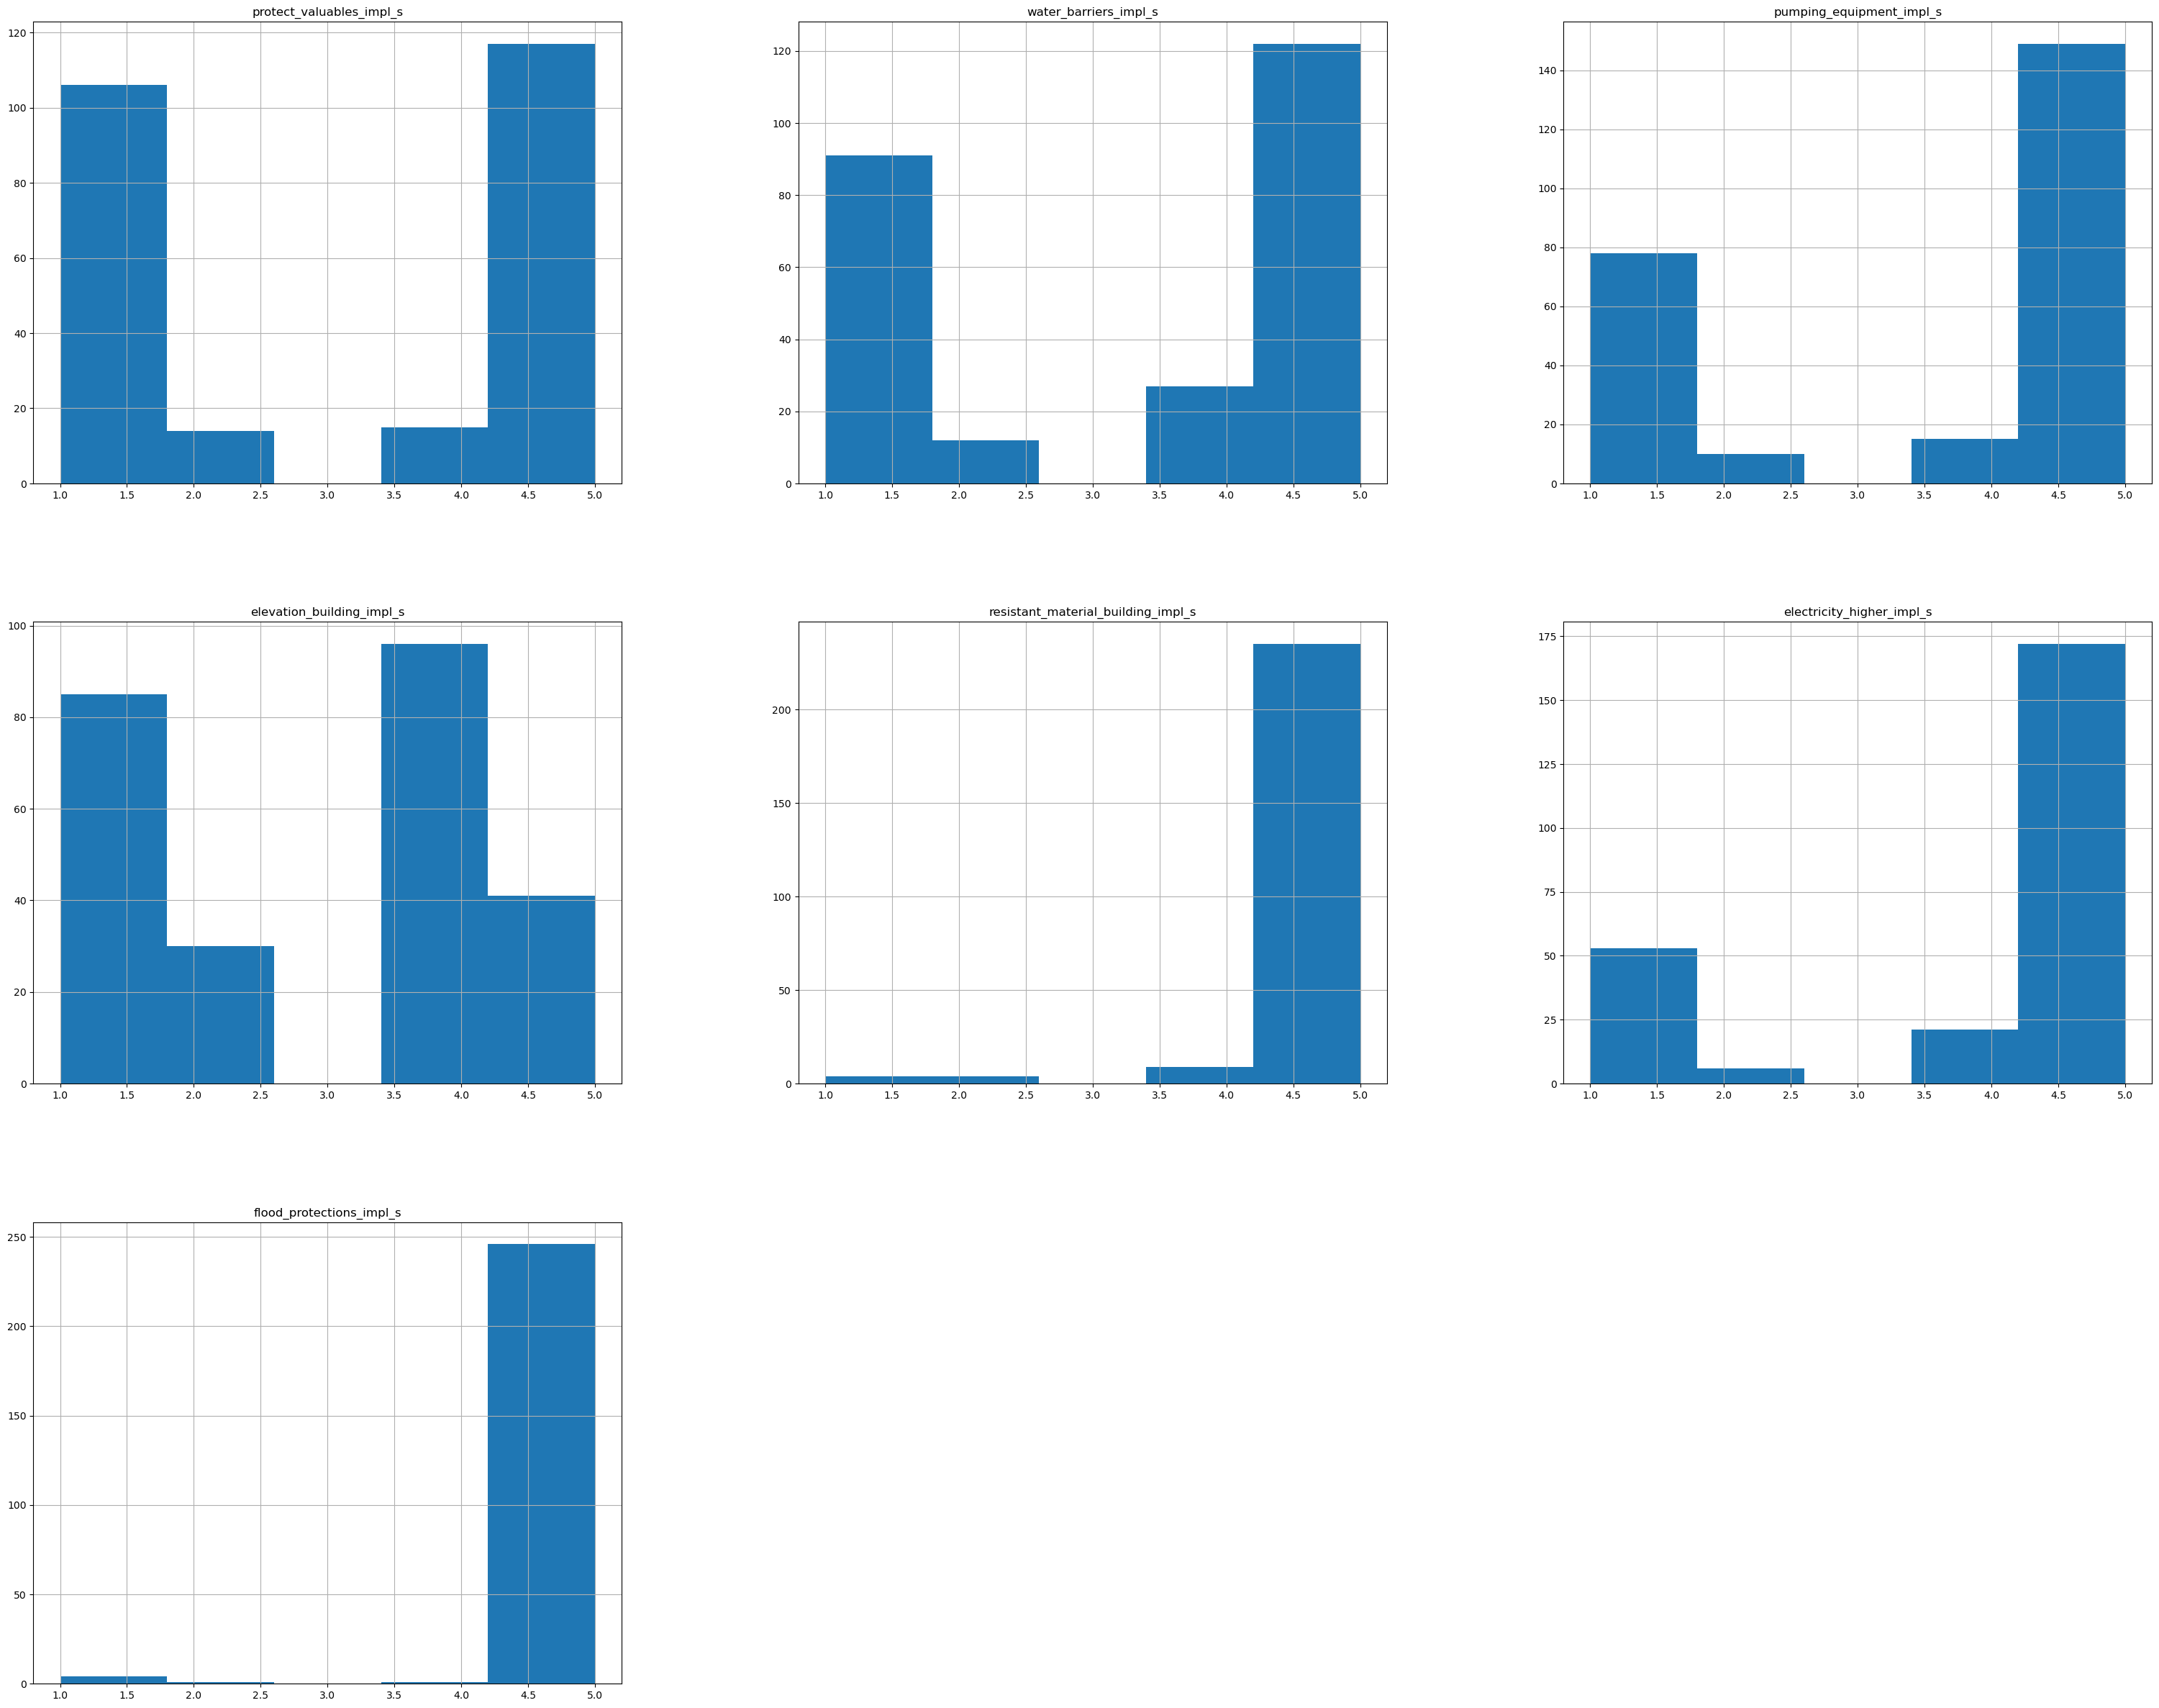

In [407]:
#vars_dam["flood_protections_impl_s"].value_counts() # 2
vars_dam[prec_measures_impl_colnames_s].hist(bins=5, figsize=(38, 30))

# pumping_equipment_impl_s	elevation_building_impl_s	resistant_material_building_impl_s	electricity_higher_impl_s	flood_protections_impl_r

### Socio-economic variables


In [408]:
part4Q1_cols_list = [r"Target_contentloss_*", r"Target_businessreduction_*", 
                        r'^hh_monthly_income_cat',  # = e.g.  "hh_monthly_income_cat"
                        r"^shp_*",  # = e.g "shp_closed_d*", r"shp_sector$", "shp_owner",
                    ]

pattern_part4Q1_cols = re.compile('|'.join(part4Q1_cols_list))
vars_soc = df.filter(regex=pattern_part4Q1_cols, axis=1)


## data cleaning
vars_soc = drop_object_columns(vars_soc)
vars_soc = drop_typos(vars_soc).astype("Float64")

#For building variables - during serious and recent events - building age; how long has the 
#householder lived in the location. LU certificate, building cost.
vars_bui = df.loc[:,['lu_cert','b_value_mVND']]
vars_bui["b_area"] = drop_typos(df.b_area)
vars_bui["b_area"]  = pd.to_numeric(vars_bui["b_area"])
flood_year_r = pd.to_datetime(df["flood_time_r"], format='mixed').dt.strftime('%Y')
flood_year_s = pd.to_datetime(df["flood_time_s"], format='mixed').dt.strftime('%Y')
 
vars_bui["flood_year_r"] = flood_year_r
vars_bui["flood_year_s"] = flood_year_s

In [409]:
#df["flood_time_r"]# 
pd.to_datetime(df["flood_time_r"], format='mixed')#.dt.strftime('%Y')

0     2015-01-01
1     2017-09-01
2     2020-08-01
3     2020-07-01
4     2020-07-01
         ...    
247   2019-10-01
248   2019-09-01
249   2017-08-01
250   2019-10-01
251   2018-09-01
Name: flood_time_r, Length: 252, dtype: datetime64[ns]

### Perception variables
The individual perception influences if meaurues for flood protection and prevention are implemented

In [410]:
vars_perception

,resilience_city_protection,resilience_more_future_affected,resilience_govern_warnings_helpful,resilience_govern_careing,resilience_govern_careing_increases,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_who_responsible4protection.Rank2,perception_who_responsible4protection.Rank3,perception_who_responsible4protection.Rank4,perception_who_responsible4protection.Rank5,perception_who_responsible4protection.Rank6,perception_who_responsible4protection.Rank7,perception_govern_support_past,perception_govern_support_future,perception_private_economy_future
0,5,2,5,5,1,2,5,2.0,1,,,,,,3.0,3,2
1,5,1,5,5,1,1,5,2.0,3,,,,,,2.0,2,99
2,4,1,2,4,2,4,4,2.0,3,4,,,,,2.0,3,2
3,5,4,1,5,1,5,5,1.0,2,,,,,,3.0,3,1
4,5,3,1,5,2,5,5,1.0,2,3,,,,,3.0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1,5,1,1,1,5,1,2.0,2,1,,,,,NaN,2,2
248,99,99,99,99,99,5,99,3.0,2,1,,,,,99.0,99,2
249,1,5,1,1,1,5,1,3.0,2,1,,,,,1.0,1,2
250,5,5,1,1,1,5,1,3.0,2,,,,,,2.0,3,1


In [411]:
part3Q1Q2_cols_list = [r"resilience_*", r"^perception_*"] 

pattern_part3Q1Q2_cols = re.compile('|'.join(part3Q1Q2_cols_list))
vars_perception = df.filter(regex=pattern_part3Q1Q2_cols, axis=1)
vars_perception = drop_object_columns(vars_perception)


## order ranks
# 1: Maintained  -> 2
# 2: Reduced  -> 1
# 3: Increased -> 3
vars_perception['perception_govern_support_past'] = vars_perception['perception_govern_support_past'].replace({2:1, 1:2})
vars_perception['perception_govern_support_future'] = vars_perception['perception_govern_support_future'].replace({2:1, 1:2})

# 1: Richer (e.g. for preparing and repairing your house) --> 3
# 2: Poorer --> 1
# 3: Same --> 2
vars_perception['perception_private_economy_future'] = vars_perception['perception_private_economy_future'].replace({2:1, 3:2, 1:3})

## replace 88 = others and typos
vars_perception = vars_perception.replace({88: np.nan, 98: np.nan})

vars_soc = pd.concat([vars_soc, vars_perception], axis=1)

### building variables

In [412]:
df.b_movingin = df.b_movingin.replace(99, np.nan)  # P4Q2.1  
df.b_year = df.b_year.replace(99, np.nan)  # P4Q2.2

## extract cases where building construction or moving in of the households was after the flood event
vars_bui["occ_yrs_r"] = flood_year_r.astype("Int64") - df.b_movingin.astype("Int64")  
vars_bui["occ_yrs_s"] = flood_year_s.astype("Int64") - df.b_movingin.astype("Int64")

vars_bui["bage_r"] = flood_year_r.astype("Int64") - df.b_year.astype("Int64")  # building age since flood event occured
vars_bui["bage_s"] = flood_year_s.astype("Int64") - df.b_year.astype("Int64")


print((vars_bui.occ_yrs_r < 0.0).sum(), "cases in which moving is after recent flood events")
print((vars_bui.occ_yrs_s < 0.0).sum(), "cases in which moving is after serious flood events")
print((vars_bui.bage_r < 0.0).sum(), "cases in which building was constructed after the recent flood event")
print((vars_bui.bage_s < 0.0).sum(), "cases in which building was constructed after the serious flood event")

#For physical damage, if the householder did not live 
#in this house during the reported flood events, we remove those records from further analysis.
#Valid = 1; not valid = 0
vars_bui['valid_r'] = 1
vars_bui['valid_s'] = 1

vars_bui.loc[vars_bui.occ_yrs_r < 0.0, "valid_r"] = 0  # set all cases which moved in or where building was constructed after event to zero
vars_bui.loc[vars_bui.occ_yrs_s < 0.0, "valid_s"] = 0



0 cases in which moving is after recent flood events
0 cases in which moving is after serious flood events
7 cases in which building was constructed after the recent flood event
7 cases in which building was constructed after the serious flood event


In [413]:
## add further building related variables likewise about elevation

#df.filter(regex="elevatio", axis=1)#.value_counts()
vars_bui[["elevation_building_height_cm", "elevation_rel2surrounding_cat", "geometry"]] = df[["elevation_building_height_cm", "elevation_rel2surrounding_cat", "geometry"]]
vars_bui = gpd.GeoDataFrame(vars_bui)

##  elevation height relatve to surrounding 
## 1 - same level, 2- house floor is lower, 3 - house floor is higher 
## for case 1 and 2 -> 0, case 3 --> 1
vars_bui["elevation_rel2surrounding_cat"] = df.elevation_rel2surrounding_cat.replace({1:0, 2:0, 3:1})


In [414]:
## add number of floors and building type from Tuebingen dataset
vars_bui["address"]  = df["housenumber_street"] 
vars_bui["floors"]  = df["Nr_Floors"] 
vars_bui["buildingtype_moon"]  = df["BT_Moon"] 
vars_bui["buildingtype_moon"]  = vars_bui["buildingtype_moon"].replace({"Shop-Traditional":0, "Shop-New":1, "Doppel/Rowhouse":2, "Rudimental":3, "Villa-Individual":4, "other":5})
# Tübing DS housenumber_street	geometry	BT_Moon	Nr_Floors	BT_TUEB_2	

## TODO impl tuebing building data



### Renovation

In [415]:
## If major renovation -> change bage to that. Otherwise, original bage

ren1= df["ren1"] # first renovation
ren2 = df["ren2"]  # second renovaton

## clean renonvation time, convert into uniform date format
ren1 = ren1.replace({r"^99":"01", np.nan:"01/01/1970", " ": "01/01/1970"}, regex=True)
ren2 = ren2.replace({r"^99":"01", np.nan:"01/01/1970", " ": "01/01/1970"}, regex=True)


## set missing days and months to 01
#ren1 = pd.to_datetime(ren1, format='mixed')
#ren2 = pd.to_datetime(ren2, format='mixed')

## fix dates for which only year exists and pass to renovation time
for i, d in enumerate(ren1):
    
    if (type(d) == int) & (len(str(d))==4):  # only year exists
        d = f"01/01/{d}"
        ren1[i] = pd.to_datetime(d, format='mixed').strftime('%m/%d/%Y')

    if (len(str(d))==7):  # only month or day and year exists
        m, y = d.split("/",1)
        d = f"{m}/01/{y}"
        ren1[i] = pd.to_datetime(d).strftime('%m/%d/%Y')


for i, d  in enumerate(ren2):
    
    if (type(d) == int) & (len(str(d))==4):  # only year exists
        d = f"01/01/{d}"
        ren2[i] = pd.to_datetime(d, format='mixed').strftime('%m/%d/%Y')
    
    if (len(str(d))==7):  # only month or day and year exists
        m, y = d.split("/",1)
        d = f"{m}/01/{y}"
        ren2[i] = pd.to_datetime(d).strftime('%m/%d/%Y')


ren1 = pd.to_datetime(ren1, format='mixed').dt.strftime('%m/%d/%Y') # convert remaining mix of formats to date
ren2 = pd.to_datetime(ren2, format='mixed').dt.strftime('%m/%d/%Y')

ren1_year = pd.to_datetime(ren1).dt.year
ren2_year =pd.to_datetime(ren2).dt.year

ren1_year = ren1_year.replace({1970:np.nan})
ren2_year = ren2_year.replace({1970:np.nan})


In [416]:
## Recent events
ren1_ev_r = flood_year_r.astype("Int64") - (ren1_year).astype("Int64")
ren2_ev_r = flood_year_r.astype("Int64") - (ren2_year).astype("Int64")

ren1_ev_r.loc[ren1_ev_r < 0] = np.nan   # replace when renovations were after flood events
ren2_ev_r.loc[ren2_ev_r < 0] = np.nan

rec_ren_year = pd.concat([ren1_ev_r, ren2_ev_r], axis=1).min(axis=1, skipna=True)


In [417]:
## Serious events 
ren1_ev_s = flood_year_s.astype("Int64") - (ren1_year).astype("Int64")
ren2_ev_s = flood_year_s.astype("Int64") - (ren2_year).astype("Int64")

ren1_ev_s[ren1_ev_s < 0] = np.nan  # replace when renovations were after flood events
ren2_ev_s[ren2_ev_s < 0] = np.nan

ext_ren_year = pd.concat([ren1_ev_s, ren2_ev_s], axis=1).min(axis=1, skipna=True)
ext_ren_year.loc[ext_ren_year<0] = df.b_year.astype("Int64")[ext_ren_year<0]
ext_ren_year.loc[ext_ren_year == 99] = np.nan

In [418]:
vars_bui["bage_ren1"] = vars_bui.bage_r.copy()
vars_bui["bage_ren2"] = vars_bui.bage_s.copy()

## if not nan than replace value in bage_ren
vars_bui.bage_ren1 = np.where( ~rec_ren_year.isna(), rec_ren_year, vars_bui.bage_ren1)
vars_bui.bage_ren2 = np.where( ~ext_ren_year.isna(), ext_ren_year, vars_bui.bage_ren2)

vars_bui.bage_ren1 = vars_bui.bage_ren1.astype("Int64")  # convert while preseving NAN
vars_bui.bage_ren2 = vars_bui.bage_ren2.astype("Int64") 

vars_bui.loc[vars_bui.bage_ren1 < 0, "bage_ren1"] = np.nan
vars_bui.loc[vars_bui.bage_ren2 < 0, "bage_ren2"] = np.nan

vars_bui.bage_r[vars_bui.bage_r < 0] = np.nan
vars_bui.bage_s[vars_bui.bage_s < 0] = np.nan


### building damage variables

Absolute and relative building loss are not calculated due that they seem to be less important for content loss modelling. 

In [419]:

# abs_loss_ev1 = df["repair_costs_building_VND_r"]  #:'P1Q3.8.1'

# # Id abs_loss is 2, then no repairs are made. One of the plausible reasons for no repairs is no damage or very minor damage. We replace these 2s by 0. 
# # Find zero-loss values
# # # Damage level (1-5): 98: not applicable; 99: I don’t know, 1: No damage; 2: Minor damages - Usable; 3: Moderate damages; 4: Major damages – needs repair; 5: Complete damage – needs replacement

# list_zero_loss_values = [1, 99, 98]

# abs_loss_ev1 = np.where(
#         (
#             (df["reason_why_not_repaired_business_r.4"]==1) | # P1Q3.10.1.4: It’s not necessary because it will be flooded soon again (1: true)
#             (df["reason_why_not_repaired_business_r.3"]==1) | # P1Q3.10.1.3: It’s not necessary (minor damages, still usable, livable) (1: true)
#             (df["overall_problem_house_r"]==1) |   # P1Q2.11.1.1: No problem (1==true)
#             (
#                 (df["damage_level_floor_r"].isin(list_zero_loss_values)) &  # P1Q3.2.1
#                 (df["damage_level_walls_r"].isin(list_zero_loss_values)) &  # P1Q3.3.1
#                 (df["damage_level_foundation_r"].isin(list_zero_loss_values)) & # P1Q3.4.1
#                 (df["damage_level_doors_r"].isin(list_zero_loss_values)) &  # P1Q3.5.1
#                 (df["damage_level_roof_r"].isin(list_zero_loss_values)) &  # P1Q3.6.1
#                 (df["damage_level_basement_r"].isin(list_zero_loss_values)) # P1Q3.7.1
#             )
#             ) & (df["repair_costs_building_VND_r"] == 2),  # P1Q3.8.1 (2: I did not repair anything)
#         0, abs_loss_ev1  
#     )

# #If no evidence of minor damage or residual damage, approximate it to what would have occured if you repaired the house completely.
# abs_loss_ev1 =  np.where(
#     (abs_loss_ev1==2) & (df["repair_costs_building_complete_mVND_r"] != 99),   # condition
#     df["repair_costs_building_complete_mVND_r"] * 1000000,  ## # condition fullfilled, set to costs to VND
#     abs_loss_ev1   # condition not fullfilled, set to 99
# )

# abs_loss_ev1 =  np.where(
#     (abs_loss_ev1==99) & (df["repair_costs_building_complete_mVND_r"] != 99),   # condition
#     df["repair_costs_building_complete_mVND_r"] * 1000000,  ## condition fullfilled, set to costs to VND
#     abs_loss_ev1  ## condition not fullfilled, set to 99
# )

# abs_loss_ev1 = pd.Series(abs_loss_ev1).astype("Int64")  # Int64 = handles nan
# abs_loss_ev1[abs_loss_ev1==99]= np.nan

In [420]:
# ## most serious

# abs_loss_ev2 = df["repair_costs_building_VND_s"]  #:'P1Q3.8.2'

# # Id abs_loss is 2, then no repairs are made. One of the plausible reasons for no repairs is no damage or very minor damage. We replace these 2s by 0. 
# # Find zero-loss values
# # # Damage level (1-5): 98: not applicable; 99: I don’t know, 1: No damage; 2: Minor damages - Usable; 3: Moderate damages; 4: Major damages – needs repair; 5: Complete damage – needs replacement

# list_zero_loss_values = [1, 99, 98]

# abs_loss_ev2 = np.where(
#         (
#             (df["reason_why_not_repaired_business_s.4"]==1) | # P1Q3.10.2.4: It’s not necessary because it will be flooded soon again (1: true)
#             (df["reason_why_not_repaired_business_s.3"]==1) | # P1Q3.10.2.3: It’s not necessary (minor damages, still usable, livable) (1: true)
#             (df["overall_problem_house_s"]==1) |   # P1Q2.11.2.1: No problem (1==true)
#             (
#                 (df["damage_level_floor_s"].isin(list_zero_loss_values)) &  # P1Q3.2.2
#                 (df["damage_level_walls_s"].isin(list_zero_loss_values)) &  # P1Q3.3.2
#                 (df["damage_level_foundation_s"].isin(list_zero_loss_values)) & # P1Q3.4.2
#                 (df["damage_level_doors_s"].isin(list_zero_loss_values)) &  # P1Q3.5.2
#                 (df["damage_level_roof_s"].isin(list_zero_loss_values)) &  # P1Q3.6.2
#                 (df["damage_level_basement_s"].isin(list_zero_loss_values)) # P1Q3.7.2
#             )
#         ) & (df["repair_costs_building_VND_s"] == 2),  # P1Q3.8.2 (2: I did not repair anything)
#         0,    # if condition fullfilled
#         abs_loss_ev2  # else 
#     )

# ## absolute losses in [VND]
# #If no evidence of minor damage or residual damage, approximate it to what would have occured if you repaired the house completely.
# abs_loss_ev2 =  np.where(
#     (abs_loss_ev2 == 2) & (df["repair_costs_building_complete_mVND_s"] != 99),   # condition
#     df["repair_costs_building_complete_mVND_s"] * 1000000,  ## # condition fullfilled, set to costs to VND
#     abs_loss_ev2   # condition not fullfilled, set to 99
# )

# abs_loss_ev2 =  np.where(
#     (abs_loss_ev2 == 99) & (df["repair_costs_building_complete_mVND_s"] != 99),   # condition
#     df["repair_costs_building_complete_mVND_s"] * 1000000,  ## condition fullfilled, set to costs to VND
#     abs_loss_ev2  ## condition not fullfilled, set to 99
# )

# abs_loss_ev2 = pd.Series(abs_loss_ev2).astype("Int64")  # Int64 = can keep nan
# abs_loss_ev2[abs_loss_ev2==99]= np.nan


#### Building value


In [421]:
vars_bui["b_value_mVND"] = df["b_value_mVND"].astype("Int64")  # = P4Q2.5: building value if sell or rebuild completely
vars_bui.b_value_mVND[vars_bui.b_value_mVND == 99.0] = np.nan


#### Content value

Derive content value (cv) from building value (bv)

Registered capital is based on bv + cv (if interviewee is owner)  
US HAZUS uses bv = 100% cv (trade, serivces), bv =150% cv (light+heavy industry, food and metall) 

similar work regarding cv: Chinh 2015, Paprotny2020

In [422]:
## due that only a few buildings have now floor info, the missing floor values are filled by the constant of 2 floors per building
print(vars_bui.floors.describe() )

vars_bui["floors"] = vars_bui["floors"].replace({np.nan:2, 0:2}).astype(int) # replace buildings with missing or unreasonable height
#print(vars_bui.floors.describe() )


count    67.000000
mean      1.701493
std       0.870648
min       0.000000
25%       1.000000
50%       2.000000
75%       2.000000
max       6.000000
Name: floors, dtype: float64


In [423]:
vars_soc.shp_registered_capital_mVND[vars_soc.shp_registered_capital_mVND == 99.0] = np.nan

vars_bui["shp_building_value_mVND"] = vars_bui.b_value_mVND / vars_bui.floors
vars_bui["shp_building_value_mVND"] = vars_bui["shp_building_value_mVND"].astype("Int64")  # Int64 = keep nan
print("Number of businesses for which registered capital is less than value for commercial building part:", (vars_soc.shp_registered_capital_mVND < vars_bui.shp_building_value_mVND).sum())
#print("No building value information: ", vars_bui.shp_building_value_mVND.isna().sum())
#print("No registered capital information: ", vars_soc.shp_registered_capital_mVND.isna().sum())

# ## quick check number of business owner
print(vars_soc.shp_owner.value_counts())  # 1- owner , 2- manager 3 - both, 88 - other


Number of businesses for which registered capital is less than value for commercial building part: 185
shp_owner
3.0     125
1.0     108
2.0      14
88.0      5
Name: count, dtype: Int64


Due that registered capital can not be used as input variable to derive content losses another apporach is utilitized:
It is tested if the updated dataset with improved geolocations and detailed building information from the Tuebingen group improves model perfomrances

In [424]:
# Alternative approach: 

vars_bui["shp_content_value_mVND"] = vars_bui.b_value_mVND  / vars_bui.floors.astype(int)  # shop cv as the ration between bv and number of floors
vars_bui["shp_content_value_mVND"] = vars_bui["shp_content_value_mVND"].astype("Int64") 
vars_bui["shp_content_value_mVND"].describe()



count         216.0
mean     496.319444
std      601.118519
min            30.0
25%           200.0
50%           350.0
75%           500.0
max          5500.0
Name: shp_content_value_mVND, dtype: Float64

In [425]:
vars_bui.buildingtype_moon.value_counts()

buildingtype_moon
0.0    48
1.0     8
5.0     6
2.0     2
3.0     2
4.0     2
Name: count, dtype: int64

### Spatial variable
*Currently not used due to the high discrepancy between geolocatio nfro mthe survey and the actual locations based on the comaprison with gmaps and OSM.*

Add information about terrain height above sea level as a predictor. This is a common approach for geograpihc related issues to improve the predictive power of multi-variate models by adding spatial information.

In [426]:
# dem__lufi_pts = gpd.read_file("../input_survey_data/DEM_LiDAR/HCMC_Lidar_2020_DEM_4326_LuFi_points.shp")  # shop locations including elevation height based on original and interpolated DEM

# dem__lufi_pts = gpd.GeoDataFrame(dem__lufi_pts,  
#             geometry=gpd.points_from_xy( 
#                      dem__lufi_pts["geometry"].x,  # lon
#                      dem__lufi_pts["geometry"].y, #lat
#             )
#         )

# ## crs of 4326 is in degree unit

In [427]:
# ## assigne DEM point locations to shp location of dataframe, silght differences in coordinates due to conversion
# vars_bui = gpd.sjoin_nearest(vars_bui, dem__lufi_pts, how='left')
# vars_bui = vars_bui.set_geometry('geometry')
# vars_bui = vars_bui.drop(["index_right"], axis=1)


In [428]:
# ## replace locations with missing elevation by interpolated DEM (all locations with missing elevation height have value 0.0 )
# #print(vars_bui[vars_bui.HCMC_Lidar==0.0])
# vars_bui.HCMC_Lidar = np.where(vars_bui.HCMC_Lidar==0.0, vars_bui.LuFIDEMInt, vars_bui.HCMC_Lidar)

In [429]:
# vars_bui = vars_bui.rename(columns={"HCMC_Lidar":"elevation_m"})
# vars_bui = vars_bui.drop("LuFIDEMInt", axis =1)
# vars_bui.insert(len(vars_bui.columns)-2, "elevation_m", vars_bui.pop("elevation_m"))


## Select predictors and merge identical events


In [430]:
vars_bui = vars_bui.drop(['occ_yrs_r', 'occ_yrs_s', 'valid_r', 'valid_s'],axis=1)


# ## column renameing for vars_soc and vars_dam was previously done 
# vars_dam["rloss_1"] = rloss_ev1
# vars_dam["rloss_2"] = rloss_ev2
# vars_dam["bloss_1"] = abs_loss_ev1
# vars_dam["bloss_2"] = abs_loss_ev2


In [431]:
vars_dam["id"] = range(len(df))

vars_dam = drop_typos(vars_dam)

## select cases with recent events and non specific cols
data_ip1 = pd.concat(
  [vars_dam.loc[:, "flood_time_r":"overall_problem_house_r.9"],  # flood vars, damage vars
    vars_dam.loc[:,"same":"flood_protections_impl_r"],  #  same, precaution measures, 
    vars_dam.loc[:,["flood_experience"]], 
    #vars_dam.loc[:, ["rloss_1", "bloss_1"]], 
 ], axis=1
)

print(f"Identical events are: {(vars_dam.same==True).sum()}")

## drop unique endings to obtain identical column names in both dfs
data_ip1.columns = data_ip1.columns.str.replace('_r', '')
data_ip1.columns = data_ip1.columns.str.replace('_1', '') 



## if not identical event select serious events
for i in range(len(data_ip1.loc[:,:])):  
  if (data_ip1.same[i]==False):   #  events are different, select also serious event
    sev = pd.concat(
        [vars_dam.loc[i, "flood_time_s" : "overall_problem_house_s.9"],  # flood-vars, damage-vars
         vars_dam.loc[i, ["same"]],
         vars_dam.loc[i, "protect_valuables_impl_s": "flood_experience"],  # precaution measures, flood experience
         #vars_dam.loc[i, ["rloss_2", "bloss_2"]]
        ]
    )

    ## convert to 1-row df, drop unique endings to merge both dfs by cols names
    sev = pd.DataFrame(sev).T
    sev.columns =sev.columns.str.replace('_s', '') 
    sev.columns =sev.columns.str.replace('_2', '') 
    sev[1:] = sev[1:].apply(pd.to_numeric)  # exclude datetime-column: flood_time

    ## append events which are not identical to a recent event
    data_ip1 = pd.concat([data_ip1, sev], ignore_index=True)



Identical events are: 107


In [432]:
vars_bui["id"] = range(len(df))

## select cases with recent events and non specific cols
data_ip2 = pd.concat(
  [vars_bui.loc[:, ["flood_year_r", "elevation_building_height_cm",	"elevation_rel2surrounding_cat"]],
    vars_bui.loc[:, ["bage_r", "b_area", "geometry"]],
    vars_bui.loc[:, ["floors", "buildingtype_moon"]], 
    vars_bui.loc[:, "shp_building_value_mVND": "id"],
    ], axis=1
)
data_ip2.columns = data_ip2.columns.str.replace('1','')
data_ip2.columns = data_ip2.columns.str.replace('_r$', '', regex=True) 

## if not identical event select serious events
for i in range(len(data_ip2.loc[:,:])): 
  if (vars_dam.same[i]==False):
    sev = pd.concat(
        [vars_bui.loc[i, ["flood_year_s", "elevation_building_height_cm",	"elevation_rel2surrounding_cat"]],
            vars_bui.loc[i, ["bage_s", "b_area", "geometry"]], 
            vars_bui.loc[i, ["floors", "buildingtype_moon"]], 
            vars_bui.loc[i, "shp_building_value_mVND": "id"]
        ]
      )
    ## convert to 1-row df, drop unique endings to merge both dfs by cols names
    sev = pd.DataFrame(sev).T
    sev.columns = sev.columns.str.replace('_s', '')
    sev.columns = sev.columns.str.replace('2$', '', regex=True) 

    ## append events which are not identical to a recent event
    data_ip2 = pd.concat([data_ip2, sev], ignore_index=True)


In [433]:
vars_soc["id"] = range(len(df))

## select cases with recent events and non specific cols
data_ip3 = pd.concat(
  [vars_soc.loc[:, ["Target_contentloss_mVND_r", "Target_businessreduction_r"]],#[:,:4],
    vars_soc.loc[:, "hh_monthly_income_cat":] #  monthly_income, firm specific variables eg. ownership, monthly sale.., resilience and perception vars
      ], axis=1
)

#sev_list = []
data_ip3.columns = data_ip3.columns.str.replace('_r$', '', regex=True) 

## if not identical event select serious events
for i in range(len(data_ip3.loc[:,:])): 
  if (vars_dam.same[i]==False):  
    sev = pd.concat(
        [vars_soc.loc[i, ["Target_contentloss_mVND_s", "Target_businessreduction_s"]],
            vars_soc.loc[i, "hh_monthly_income_cat":]
        ], 
      )
    ## convert to 1-row df, drop unique endings to merge both dfs by cols names
    sev = pd.DataFrame(sev).T
    sev.columns = sev.columns.str.replace('_s$', '', regex=True) 

    #sev_list.append(sev)
    ## append not identical events to end of df
    data_ip3 = pd.concat([data_ip3, sev], ignore_index=True)


### Combine all important variabels 

In [434]:
## merged cases
all_input = pd.concat(
        [data_ip1.loc[:, data_ip1.columns != 'id'], 
        data_ip2.loc[:, data_ip2.columns != 'id'],
        data_ip3
        ], axis=1
)

In [435]:
print(all_input.shape) 

(397, 83)


Number of cases is larger than from Rscript, due that col "same" incoporates flood times and more varibles are used.

 2*145 + 1 * 107 = 397 cases [count different events twice, identical events once]

## Feature reduction


Simple approaches to reduce Multicollinearity:
- zero variance features
- Remove some of the highly correlated independent variables - Not APPLIED yet in subsequent part of the script - their influence in FS models is tested first and than they will be removed here and a combined indicator for resilience features will be tested on model performance
- Linearly combine the independent variables, such as adding them together - APPLIED in subsequent part of the script
- Partial least squares regression uses principal component analysis to create a set of uncorrelated components to include in the model.
- apply regularized linear models such as elastic net - APPLIED in Feature selection section
Some features might be less important for model performance, they are left in feature space so far.


#### Minor cleaning 

Fix commas and 99, empty columns, spatial drop

Empty cells or the interviewee could not answer the question (“I don’t know”) were all set to missing number (not a number: NaN) and for dates to missing date (not a date: NaT). Nulls were left unchanged, ie. for the target variables for which it is assumed that the interviewee had no direct or indirect content losses.

In [436]:
# fix data types
all_input.flood_time = pd.to_datetime(all_input.flood_time, format='mixed')


## fix obj columns - convert to numeric by keeping nan values
all_input_obj = all_input.select_dtypes(include=object)  # all obj cols
all_input_obj =all_input_obj.drop("geometry", axis=1)

for c in all_input_obj.columns:
    all_input[c]  =  drop_typos(all_input_obj[c]).apply(pd.to_numeric)  # convert to int or float,  handles NAN

all_input = all_input.replace(99, np.nan)

#### Shops in large buildings 
Remove busineses which are located in buidligns with more than 3 floors, due that approximation is getting less exact due to small sample size.

In [437]:
print(all_input.shape)
print(f"Remove {all_input[all_input['floors'] > 3.0].shape[0]} records which have shops located in larger buildings")
all_input = all_input[ ~(all_input["floors"] > 3.0)]


(397, 83)
Remove 4 records which have shops located in larger buildings


### Variance and collinearity of features before Feature Reduction

Remove features with zero or near zero variance or merge them into indicators. Do this in respect to the amount of missing data stored in the features. Reduce colinearity between similar features by mergin them into indicators

In [438]:
## drop of columns which were only needed to develop the datasets

all_input = all_input.drop(
    [
        "flood_time", "flood_year", "id", "same", "geometry", 
    ],  
    axis=1
    )

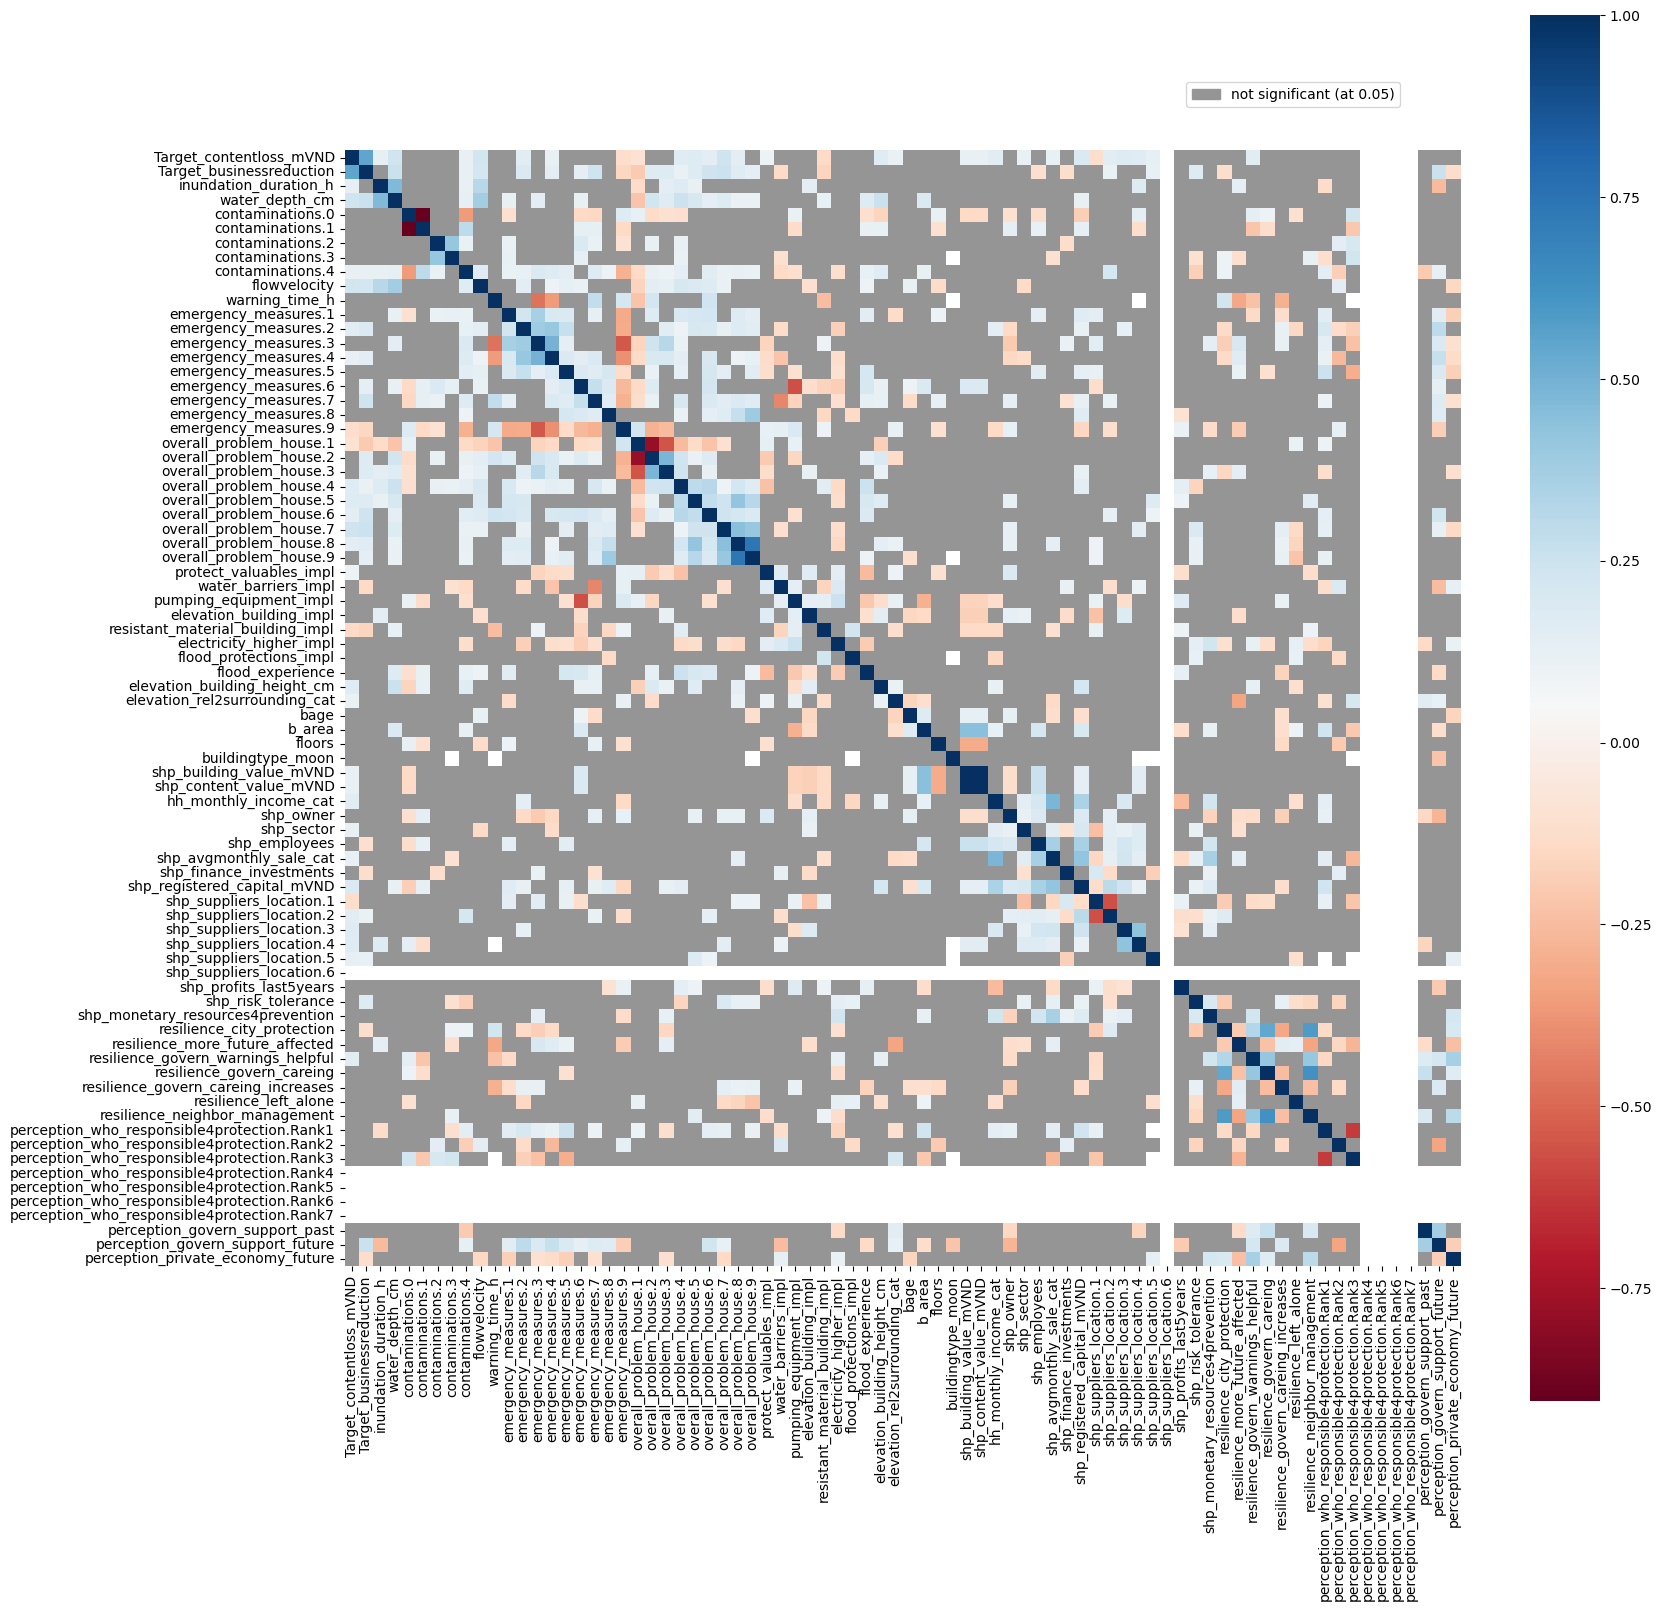

In [439]:
## move targets to beginning
all_input.insert(0, "Target_contentloss_mVND", all_input.pop("Target_contentloss_mVND"))
all_input.insert(1, "Target_businessreduction", all_input.pop("Target_businessreduction"))

plt.figure(figsize=(18,18))
f.plot_spearman_rank(all_input, min_periods=50, signif=True, psig=0.05)


In [440]:
X_scaled = MinMaxScaler().fit_transform(
    all_input.drop(
        ["Target_contentloss_mVND", "Target_businessreduction"], 
        axis=1
    )
)
X_scaled = pd.DataFrame(
    X_scaled,
    columns=all_input.drop(["Target_contentloss_mVND", "Target_businessreduction"], axis=1).columns
)


df_variance = X_scaled.var()
df_variance = np.round(df_variance, 5)
print(pd.DataFrame({"variance":df_variance}).sort_values("variance").head(25))

var = []
for i in range(0, len(df_variance)):
    if df_variance[i] != 0.00000:
            var.append(X_scaled.columns[i])
df_variance = pd.DataFrame({"variance":df_variance}).sort_values("variance")

                                             variance
perception_who_responsible4protection.Rank7   0.00000
perception_who_responsible4protection.Rank6   0.00000
perception_who_responsible4protection.Rank5   0.00000
shp_suppliers_location.6                      0.00000
shp_registered_capital_mVND                   0.00309
shp_employees                                 0.00385
inundation_duration_h                         0.00499
shp_suppliers_location.5                      0.00508
shp_content_value_mVND                        0.00951
shp_building_value_mVND                       0.00951
b_area                                        0.00991
shp_suppliers_location.4                      0.01010
overall_problem_house.9                       0.01507
flood_protections_impl                        0.01904
shp_owner                                     0.01962
bage                                          0.01965
elevation_building_height_cm                  0.02237
hh_monthly_income_cat       

In [441]:
print("Percentage of missing values per feature [%]\n", round(all_input.isna().mean().sort_values(ascending=False)[:20]  * 100), 2) 


Percentage of missing values per feature [%]
 perception_who_responsible4protection.Rank7    99.0
perception_who_responsible4protection.Rank6    99.0
perception_who_responsible4protection.Rank5    99.0
perception_who_responsible4protection.Rank4    91.0
warning_time_h                                 78.0
buildingtype_moon                              73.0
perception_who_responsible4protection.Rank3    69.0
perception_who_responsible4protection.Rank2    39.0
perception_govern_support_past                 38.0
perception_govern_support_future               34.0
elevation_building_height_cm                   16.0
shp_content_value_mVND                         16.0
shp_building_value_mVND                        16.0
resilience_govern_careing_increases            14.0
shp_registered_capital_mVND                    12.0
Target_businessreduction                        9.0
shp_risk_tolerance                              7.0
bage                                            7.0
perception_who_res

In [442]:
## drop frther columns which were only needed to develop the datasets, are qualitative features or are empty

all_input = all_input.drop(
    [
        "warning_time_h", # less importnat for a flood-proven society and contains many missing values 
        "shp_suppliers_location.1", "shp_suppliers_location.2", "shp_suppliers_location.3",   #  qualitative variables not usable for Bayesian Network
        "shp_suppliers_location.4", "shp_suppliers_location.5", "shp_suppliers_location.6",
        "shp_sector",  # qualitative variable not usable in NPBN for continous variables
        "shp_owner",   # qualitative variable not usable in NPBN for continous variables
        "perception_who_responsible4protection.Rank7",   # empty features + qualitative feature
        "perception_who_responsible4protection.Rank6", "perception_who_responsible4protection.Rank5", # empty features + qualitative feautre
        "perception_who_responsible4protection.Rank4", "perception_who_responsible4protection.Rank3",
        "perception_who_responsible4protection.Rank2", "perception_who_responsible4protection.Rank1",
        "buildingtype_moon",  #  qualitative variables not usable for Bayesian Network
        "shp_building_value_mVND", # not seen as potential predictor fro both target variables
        "overall_problem_house.1",  # only inidcating if a problem on the building occured or not -> its infomration is captured by similar features
    ],  
    axis=1
    )

Based on the variance of the features, collineraties and the amount of missing values er feature following decisions are done:

**Merge**
- merge contamination to one or two indicators (if two indicators: one for light and one for heavy contamination)
- merge emergency measures to ratio of implemented / potentially implemented
- merge resilience predictors or remove them, due that no monotonic relation could be seen to both target variables
- merge perception predictors if possible
- combine damages on the building into a single predictor ("overall_problem_house"). stronger damage on walls/floor -> can influence flood-losses on shop content . Cracks, mold, stronger damage on walls/floor  --> the length of business reduction.
It is assumed that stronger building damages influence content loss and business reduction much more than minor building damages. Minor damages might not at all influence the resposne variables 

**Remove**

--> remove all features for perception_who_repsonsible4protection due that the only remaining Rank is binary and wouldnt be usable in the final Bayesian network version which relys on continous data. Moreover the Ranks are qualitative

--> remove warning_time_h : assumed that it is less important predictor for a flood-proven society

--> remove shp_supplier_locations due that they are qualitative e.g. the distance to a supplier outside the city can be shorter than to another supplier located inside the city but in a far away district

**Keep**

Keep following features with low variation due that they are seen in other studies as important predictors. 
Likewise socio-economic features and predictors describing the shop characteristics seemst to be potential important flood-loss influencing variables 
- b_area, 
- shp_registered_capital_mVND, 
- shp_employees, 
- inundation_duration_h, 
- shp_content_value_mVND 


Keep all resilience related features. they are potentially captured by implemented precaution and emergency measures, but this relation can be tested in the Bayesian network if needed [ 'resilience_city_protection', 'resilience_left_alone',
      'resilience_neighbor_management', 'resilience_more_future_affected','resilience_govern_careing', 'resilience_govern_careing_increases',
]

*Some features might be less important for model performance, they are left in feature space so far*

#### Major Cleaning
Remove further columns which are not needed as predictors 

In [443]:
all_input = all_input.drop([
      #"perception_govern_support_past",
      #"perception_govern_support_future",
      #"perception_private_economy_future",
      "shp_profits_last5years", # information can be captured in e.g. precuationary measures, e.g. increased profits --> purchased more precautionry meausres
      "emergency_measures.5", # saving elderly and kids -> not important for commercial sector
      "emergency_measures.6", # pumping eq captured in Precautionary measures, 
      "emergency_measures.9", # action/no action
      #"elevation_building_height_cm",  # keep it due its small multicollinearity, still its information is included in elevation_impl 
      "elevation_rel2surrounding_cat",  # remove due that its information is covered in other elevation features
      "shp_monetary_resources4prevention", # TEST
      'shp_finance_investments',
      #'shp_risk_tolerance',
      ], axis=1)
    

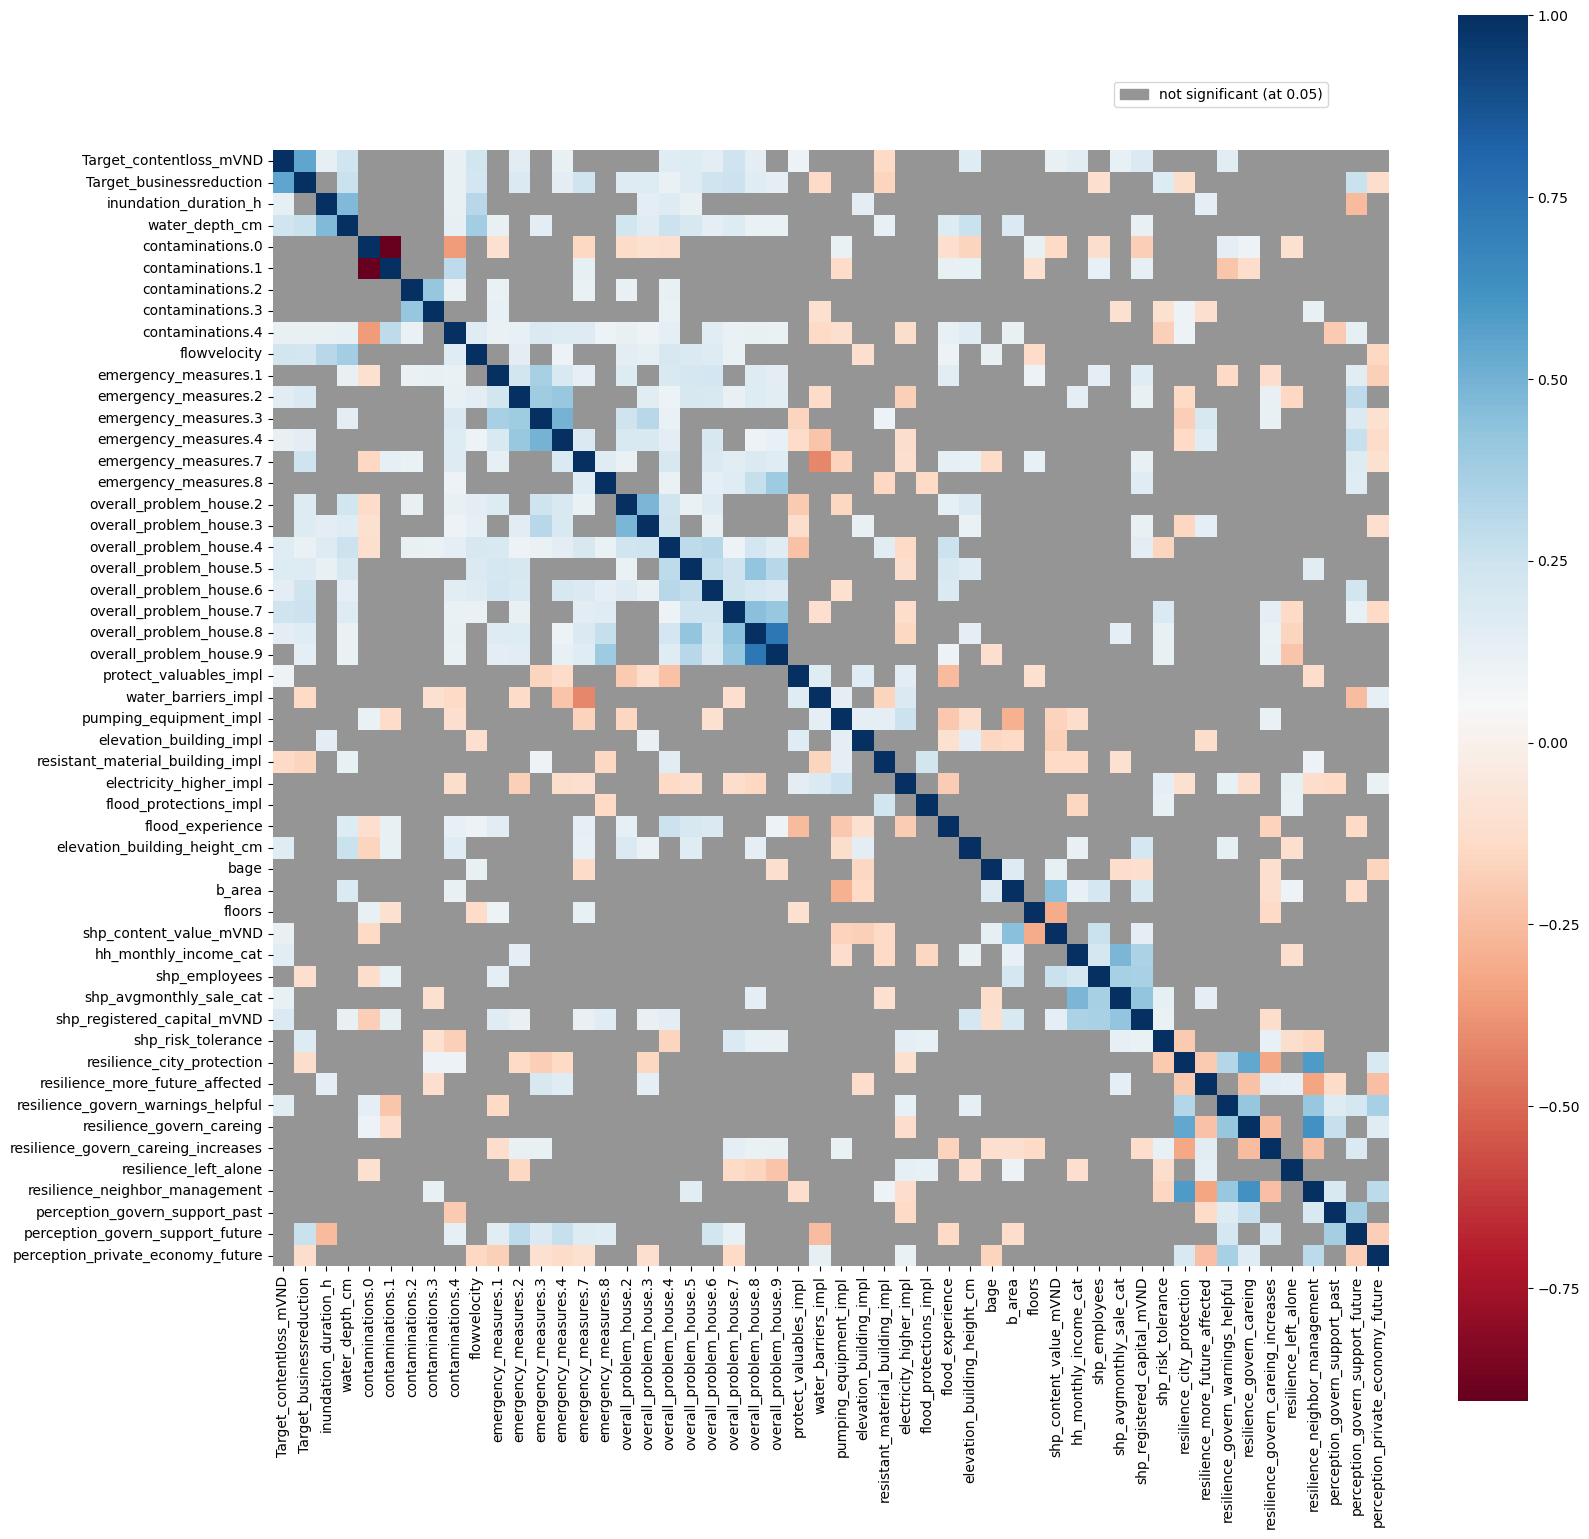

In [444]:
import utils.utils_figures as f

plt.figure(figsize=(18,18))
f.plot_spearman_rank(all_input, min_periods=50, signif=True, psig=0.05)


### Multicollinearity

- VIF >10 : high correlation with other features
- VIF <5: medium correlation

**Mulitcollinear features are only explored -> the results are implemented in chapter "Indicators"** 

In [505]:
## first reduce multicollineary in predictor set by normalization, this can be done due that the later applied ML models will uses only nomralized predictors. 
## Our goal is to have less multicollineary in our model training to have meaningfull feautre importance, therefore normalization can already applied here to deterine multicollinearity
## Normalization already reduces the avarge VIF score remarkably 

X = all_input.drop(["Target_contentloss_mVND", "Target_businessreduction"], axis=1)
## reset index due that some samples are removed
X = X.reset_index(drop=True)

scaler = MinMaxScaler()
d = scaler.fit_transform(X)
X_scaled = pd.DataFrame(d, columns=X.columns)
X_scaled.head(5)

,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.7,emergency_measures.8,overall_problem_house.2,overall_problem_house.3,overall_problem_house.4,overall_problem_house.5,overall_problem_house.6,overall_problem_house.7,overall_problem_house.8,overall_problem_house.9,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,elevation_building_height_cm,bage,b_area,floors,shp_content_value_mVND,hh_monthly_income_cat,shp_employees,shp_avgmonthly_sale_cat,shp_registered_capital_mVND,shp_risk_tolerance,resilience_city_protection,resilience_more_future_affected,resilience_govern_warnings_helpful,resilience_govern_careing,resilience_govern_careing_increases,resilience_left_alone,resilience_neighbor_management,perception_govern_support_past,perception_govern_support_future,perception_private_economy_future
0,0.003001,0.060403,1.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.75,1.0,1.0,1.0,0.8,0.269231,0.12,0.013158,0.5,0.003656,0.142857,0.0,0.2,0.000211,0.0,1.00,0.25,1.00,1.00,0.00,0.25,1.00,1.0,1.0,0.5
1,0.003001,0.093960,0.0,1.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.75,1.0,1.0,1.0,0.8,0.230769,0.00,0.009109,0.5,0.003656,0.285714,0.0,0.2,0.000474,0.0,1.00,0.00,1.00,1.00,0.00,0.00,1.00,0.5,0.5,NaN
2,0.001334,0.006711,1.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1.0,0.0,1.0,0.8,0.153846,0.21,0.038462,0.0,0.159049,0.428571,0.0,0.0,0.000474,0.0,0.75,0.00,0.25,0.75,0.25,0.75,0.75,0.5,1.0,0.5
3,0.004668,0.060403,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.00,1.0,0.0,1.0,0.4,NaN,0.20,0.013158,1.0,0.018830,0.142857,0.0,0.0,NaN,0.0,1.00,0.75,0.00,1.00,0.00,1.00,1.00,1.0,1.0,0.0
4,0.004668,0.026846,0.0,1.0,0.0,0.0,1.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.00,1.0,0.0,1.0,0.4,0.000000,0.20,0.068826,0.0,0.159049,0.285714,0.0,0.0,0.000000,0.0,1.00,0.50,0.00,1.00,0.25,1.00,1.00,1.0,1.0,0.0


In [506]:
# print("Percentage of missing values per feature [%]\n", round(X_scaled.isna().mean().sort_values(ascending=False)[:20]  * 100), 2) 


In [513]:
df_vif = pd.DataFrame()
df_vif["X_features"] =  X_scaled.columns

## fill features with the most of missing values with median, only for VIF calculation
for feature in ["shp_registered_capital_mVND", "elevation_building_height_cm",  
                "shp_content_value_mVND", "resilience_govern_careing_increases",
                "perception_govern_support_future", "perception_govern_support_past"]:
    X_scaled[f"{feature}"] = X_scaled[f"{feature}"].replace(np.nan, np.nanmedian(X_scaled[f"{feature}"]))


X_scaled_drop_nan = X_scaled.dropna()
X_scaled_drop_nan = X_scaled_drop_nan.reset_index(drop=True)

print(X_scaled.shape)
print(X_scaled_drop_nan.shape)

df_vif = fs.vif_score(X_scaled_drop_nan)
print(df_vif.sort_values("vif_scores", ascending=False).head(15)  )


(393, 50)
(267, 50)
averaged VIF score is around:  10.1
                               names  vif_scores
0             flood_protections_impl   77.853865
1                   contaminations.1   67.540350
2   resistant_material_building_impl   44.646326
3              resilience_left_alone   41.813145
4   perception_govern_support_future   32.409400
5                   flood_experience   14.415747
6            overall_problem_house.2   11.881661
7     perception_govern_support_past   11.150897
8              hh_monthly_income_cat   10.579565
9                             floors   10.365659
10    resilience_neighbor_management    9.814174
11                  contaminations.0    9.381646
12   resilience_more_future_affected    9.139516
13         resilience_govern_careing    8.044202
14                     shp_employees    7.926294


The average degree of Multicollinearity is quite high with a score of around 10.

As already seen in the previous Spearman Rank Order matrics, some features should be merged into a single indicator or alternatively should be removed from feature space if they are not important.
- contaminiations into one or two indicators 
- overall_problem_house features: merge into indicator
-  perception features: merge into indicator
-  resilience features: merge into indicator


Other strong collinear features are left unchanged .e.g precuationary measures (*_impl) in the dataset due that they seem to be important

*Merge the aforementioned feautres and check the VIF scores again*

In [514]:
X_scaled_drop_nan["contaminations"] = None
X_scaled_drop_nan["overall_problem_house"] = None
X_scaled_drop_nan["emergency_measures"] = None


# rank contamination according to their occurence and damage potential: 0:no contamination, 1:light contamination and 2:heavy contamination
## light contamination
X_scaled_drop_nan.contaminations = np.where( 
    (X_scaled_drop_nan["contaminations.1"]==1) | 
    (X_scaled_drop_nan["contaminations.4"]==1) ,
    1, 0
) 
## heavy contamination
idx_heavy_contamination = np.where(
    (X_scaled_drop_nan["contaminations.2"]==1) |
    (X_scaled_drop_nan["contaminations.3"]==1)
)
X_scaled_drop_nan.contaminations[idx_heavy_contamination[0].tolist()] = 2


## overall problem building
X_scaled_drop_nan.overall_problem_house = np.where( (X_scaled_drop_nan["overall_problem_house.2"]==1), 1, 0) 

idx = np.where(X_scaled_drop_nan["overall_problem_house.3"]==1)
X_scaled_drop_nan.overall_problem_house[idx[0].tolist()] = 2

idx = np.where(X_scaled_drop_nan["overall_problem_house.4"]==1)
X_scaled_drop_nan.overall_problem_house[idx[0].tolist()] = 3

idx = np.where(X_scaled_drop_nan["overall_problem_house.5"]==1)
X_scaled_drop_nan.overall_problem_house[idx[0].tolist()] = 4

idx = np.where(X_scaled_drop_nan["overall_problem_house.6"]==1)
X_scaled_drop_nan.overall_problem_house[idx[0].tolist()] = 5

idx = np.where(
    (X_scaled_drop_nan["overall_problem_house.7"]==1) | 
    (X_scaled_drop_nan["overall_problem_house.8"]==1) |
    (X_scaled_drop_nan["overall_problem_house.9"]==1)
)
X_scaled_drop_nan.overall_problem_house[idx[0].tolist()] = 6


## emergency easures - merged binray feautres into on multiclass inidcator 
pattern = [r"emergency_measures.?"] 
pattern_cols = re.compile('|'.join(pattern))
df_emergency = X_scaled_drop_nan.filter(regex=pattern_cols, axis=1)
## create indicator as ratio between implemented and potentially implemented emergency measures
X_scaled_drop_nan["emergency_measures"] = df_emergency.eq(1).sum(axis=1) #/ len(df_emergency.columns)



X_scaled_drop_nan = X_scaled_drop_nan.drop([
            "contaminations.0", "contaminations.1", "contaminations.4", 
            "contaminations.2", "contaminations.3",
            "overall_problem_house.2", "overall_problem_house.3", "overall_problem_house.4",
            "overall_problem_house.5", "overall_problem_house.6", "overall_problem_house.7", "overall_problem_house.8",
            "overall_problem_house.9",
            "emergency_measures.1", "emergency_measures.2", "emergency_measures.3", "emergency_measures.4",
            "emergency_measures.7", "emergency_measures.8",
            ], axis=1)


In [515]:
df_vif = fs.vif_score(X_scaled_drop_nan)
print(df_vif.sort_values("vif_scores", ascending=False).head(15)  )

averaged VIF score is around:  9.6
                               names  vif_scores
0             flood_protections_impl   58.837339
1              resilience_left_alone   37.653157
2   resistant_material_building_impl   35.981439
3   perception_govern_support_future   29.374912
4                   flood_experience   12.656226
5     perception_govern_support_past    9.967349
6              hh_monthly_income_cat    9.724793
7                             floors    9.141927
8     resilience_neighbor_management    8.511833
9    resilience_more_future_affected    8.116278
10                    contaminations    7.584711
11         resilience_govern_careing    7.239030
12                     shp_employees    7.223723
13                emergency_measures    6.044282
14        resilience_city_protection    5.963418


The again applied VIF score shows that merging contaminations, overall problem of the house and emergency measures into single indicators  reduces the average VIF score slightly under 10.

--> perception and resilience featues should be combined as inidcators or be removed 

*Be aware* : By merging feautres into indicators, information can be lost or remarkable characteristics of one feature are less expressive in a combined indicator than compared to nth single features

*Be aware* : removing features with high collinearity from the dataset changes the VIF score of the remaining feautres, so only removing feautres is not a good solution to reduce multicollinearity

- VIF >10 : high correlation with other features
- VIF <5: medium correlation


### PCA on subset of features

*Find out if perception and resilience could be merged into indicators* 

### Indicators and transform categorical variables
Based on the above findings from VIF and spearman correlation plot certain features from the original feature space will be merged into indicators:

The later applied Bayesian Network uses continous variables, therfore categorical variables are transformed to continous scales if possible.
Ordered categories can be easily transformed when they are in quantitative values, while binary or qualitative variables can not be used in the Bayesian Network


#### Variables to modify:

binary vars: --> remove or modify
- contaminaitions : modify to indicator

categ vars:
- DONE flowvelocity : m/sec -> paper paprotny 2021 for residential loss
- DONE flood exp: convert to mean of range - 
- DONE shp_avgmonthly_sale_cat
- DONE hh_monthly_income_cat
- DONE sectors remove due that qualitative
- DONE merge emergyency measures : paprotny indicator
- DONE merge precautionary ()impl
- DONE shp_supplier location - ranked by location (only for business reduction)
- DONE merge resilience
- DONE merge perception
- DONE overall_problem_house --> test as multiclass variable




In [1072]:
## flow velocity: categories 1:calm - 5:torrential
## Paprotny 2021:  As for flow velocity, the respondents assessed it based on a qualitative scale, providing a value from 1 to 6, with half-points possible (Thieken et al. 2005). A value of 0.1 m/s was assigned to each full step of this qualitative scale. 

# sns.scatterplot(
#     data=all_input, 
#     x="flowvelocity", 
#     #x="water_depth_cm", 
#     y=target, 
#     #hue="size", #style="time"
# )

all_input.flowvelocity.describe()

all_input.flowvelocity = all_input.flowvelocity.replace(
    {
        1:0.1, 
        2:0.2, 
        3:0.3, 
        4:0.4, 
        5:0.5
    }
)


In [1073]:
## flood experience: mean of ranges
all_input.flood_experience.describe()

all_input.flood_experience = all_input.flood_experience.replace(
    {
      1:3,     # less than once a year , freq: 1
      2:8,     # about once a year, freq: 14
      3:16,      # twice a year, freq: 37
      4:36,      # 4 times a year, freq: 58
      5:76,      # 8 times a year, freq: 98
      6:151     # 15 times a year - used range 100-200, freq: 112 (more than 10 times a year, 100 times since 2010)
    }
)


In [1074]:
## avg monthly sale (million VND/month)
all_input.shp_avgmonthly_sale_cat.value_counts()

all_input["shp_avgmonthly_sale"] = None
all_input["shp_avgmonthly_sale"] = all_input.shp_avgmonthly_sale_cat.replace(
    {
      1:2.5,     # < 5m , freq: 126
      2:7.5,     # 5m – 10m , freq: 129
      3:20,      # 10m – 30m , freq: 54
      4:40,      # 30m – 50m , freq: 7
      5:75,      # 50m – 100m , freq: 8
    }
)

In [1075]:
## avg monthly income
#print(all_input.hh_monthly_income_cat.value_counts())

all_input["hh_monthly_income"] = None
all_input.hh_monthly_income = all_input.hh_monthly_income_cat.replace(
    {
      1:0,     # < 1m , freq: 4
      2:3,     # 1m – 5m , freq: 68
      3:8,     # 5m – 10m , freq: 153
      4:15,    # 10m – 20m , freq: 111
      5:25,    # 20m – 30m , freq: 26
      6:40,    # 30m – 50m , freq: 4
      7:65,    # 50m – 80m , freq: 4
      8:90,    # 80m – 100m , freq: 3
    }
)

all_input.drop(["hh_monthly_income_cat", "shp_avgmonthly_sale_cat"], axis=1, inplace=True)

#### Indicators
indictator for severla multiple choice answers e..g emergency and precautionary measures

as a ratio between b measures implemented prior to the flood (nI) divided by the nb measures potentailly could have implemented (nP)
(https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020WR027649)

Maybe socio-economic status indicator:

according to Plapp 2003, applied by Thieken et al 2005
indicator of warning information, indicator of emergency measures, perception of efficiency of private precaution, building quality, building/content value

In [1076]:
df = all_input
df.columns

df = df.reset_index(drop=True)

In [1077]:
## emergency measures as indicator : range: 0:no measures - 6: applied all measures 

pattern = [r"emergency_measures.?"] 
pattern_cols = re.compile('|'.join(pattern))
df_emergency = df.filter(regex=pattern_cols, axis=1)

## create indicator as ratio between implemented and potentially implemented emergency measures
df["emergency_measures"] = None
df["emergency_measures"] = df_emergency.eq(1).sum(axis=1) / len(df_emergency.columns)

# keep only indicator in final df
df.drop(
    df_emergency.filter(
        regex=r"^(?:.+\d)$"
        ).columns, 
    axis=1, inplace=True
)

In [1078]:
df.emergency_measures.value_counts()
#df_precautionary

emergency_measures
0.5    101
0.3     88
0.0     64
0.7     56
0.2     45
0.8     32
1.0      7
Name: count, dtype: int64

In [1079]:
## precautionary measures as indicator
## --> test as seperate feautres to keep as much information as possible

pattern = [r"_impl$"] 
pattern_cols = re.compile('|'.join(pattern))
df_precautionary = df.filter(regex=pattern_cols, axis=1)

## create ratio: 
## -> precaution inidcator. 5:0 - not impl, 4:1 - after both,  2:2- after event but before recent, 1:3- before event
# Precuationary measures: 
# 1: impl before event, 
# 2: impl after serious event but before recent event, TODO check for recent/serious cases: probably occurs only for rencet cases --> than count as 1
# 4: impl after event
# 5: didnt impl

df_precautionary = df_precautionary.replace(
    {
        1:1,    # impl before 
        2:0,    # impl after event but before recent 
        4:0,    # impl after 
        5:0     # not at all  
    }
)
## devide into expensive and low cost precautionary measures due that expensive meausres seems to be better in flood-loss-reduction
# df_precautionary_expensive = df_precautionary[["elevation_building_impl", "resistant_material_building_impl"]]
# df_precautionary_low = df_precautionary.drop(["elevation_building_impl", "resistant_material_building_impl"], axis=1)

## create indicator as ratio between implemented and potentially implemented measures (in total 7 measures exist)
## range: 0.0: no measure wa implemented before the flood event - 1.0: all potential measures were implemented before the reported flood
## --> splitting in low and expensive precaution measures reduces the importance of the feautres for the models remarkable
# df["precautionary_measures_lowcost"] = None
# df["precautionary_measures_lowcost"] = df_precautionary_low.sum(axis=1) / len(df_precautionary_low.columns)
# df["precautionary_measures_expensive"] = None
# df["precautionary_measures_expensive"] = df_precautionary_expensive.sum(axis=1) / len(df_precautionary_expensive.columns)

df["precautionary_measures"] = df_precautionary.sum(axis=1) / len(df_precautionary.columns)


## keep only indicator in final df
df.drop(
    df_precautionary.columns, 
    axis=1, inplace=True
)
print(df.columns)


Index(['inundation_duration_h', 'water_depth_cm', 'contaminations.0',
       'contaminations.1', 'contaminations.2', 'contaminations.3',
       'contaminations.4', 'flowvelocity', 'overall_problem_house.1',
       'overall_problem_house.2', 'overall_problem_house.3',
       'overall_problem_house.4', 'overall_problem_house.5',
       'overall_problem_house.6', 'overall_problem_house.7',
       'overall_problem_house.8', 'overall_problem_house.9',
       'flood_experience', 'elevation_building_height_cm', 'bage', 'b_area',
       'floors', 'shp_content_value_mVND', 'Target_contentloss_mVND',
       'Target_businessreduction', 'shp_employees',
       'shp_registered_capital_mVND', 'shp_suppliers_location.1',
       'shp_suppliers_location.2', 'shp_suppliers_location.3',
       'shp_suppliers_location.4', 'shp_suppliers_location.5',
       'resilience_city_protection', 'resilience_more_future_affected',
       'resilience_govern_warnings_helpful', 'resilience_govern_careing',
       'resi

In [1080]:
# df["precautionary_measures"].value_counts()

In [1081]:
## resilience as indicator:
## 1 : strong diagree - 5 : strong agree
## currently would leave at it is and see if its included in final Feature space
## TEST: as merged indcator and as seperate features
## o	Orderer rank okay as long its  quantitative

df_resilience = df.filter(like="resilience_", axis=1)
df_resilience

df["resilience"] = None
df["resilience"] = df_resilience.sum(axis=1) / len(df_resilience.columns)

## keep only indicator in final df
df.drop(
    df_resilience.filter(
        regex=r"^(resilience_)*"
        ).columns, 
    axis=1, inplace=True
)
print(df.columns)


Index(['inundation_duration_h', 'water_depth_cm', 'contaminations.0',
       'contaminations.1', 'contaminations.2', 'contaminations.3',
       'contaminations.4', 'flowvelocity', 'overall_problem_house.1',
       'overall_problem_house.2', 'overall_problem_house.3',
       'overall_problem_house.4', 'overall_problem_house.5',
       'overall_problem_house.6', 'overall_problem_house.7',
       'overall_problem_house.8', 'overall_problem_house.9',
       'flood_experience', 'elevation_building_height_cm', 'bage', 'b_area',
       'floors', 'shp_content_value_mVND', 'Target_contentloss_mVND',
       'Target_businessreduction', 'shp_employees',
       'shp_registered_capital_mVND', 'shp_suppliers_location.1',
       'shp_suppliers_location.2', 'shp_suppliers_location.3',
       'shp_suppliers_location.4', 'shp_suppliers_location.5',
       'shp_avgmonthly_sale', 'hh_monthly_income', 'emergency_measures',
       'precautionary_measures', 'resilience'],
      dtype='object')


In [1082]:
## perception as indicator
## currently would leave at it is and see if its included in final Feature space
## o	Orderer rank okay as long its  quantitative

## 1 : strong diagree - 5 : strong agree
## currently would leave at it is and see if its included in final Feature space
## TEST: as merged indcator and as seperate features
## o	Orderer rank okay as long its  quantitative

# df_perception = df.filter(like="perception_", axis=1)
# df_perception

# df["perception"] = None
# df["perception"] = df_perception.sum(axis=1) / len(df_perception.columns)

# ## keep only indicator in final df
# df.drop(
#     df_perception.filter(
#         regex=r"^(perception_)*"
#         ).columns, 
#     axis=1, inplace=True
# )

In [1083]:
## contaminations
## rank contamination according to their occurence and damage potential: 0:no contamination, 1:light contamination and 2:heavy contamination

df["contaminations"] = None
df_contaminations = df.filter(like="contaminations", axis=1)


## light contamination
df.contaminations = np.where( 
    (df_contaminations["contaminations.1"]==1) | 
    (df_contaminations["contaminations.4"]==1) ,
    1, 0
) 
## heavy contamination
idx_heavy_contamination = np.where(
    (df_contaminations["contaminations.2"]==1) |
    (df_contaminations["contaminations.4"]==1)
)
df.contaminations[idx_heavy_contamination[0].tolist()] = 2


## keep only indicator in final df
df.drop(
    df_contaminations.filter(
        regex=r"^(contaminations.?)"
        ).columns, 
    axis=1, inplace=True
)
#print(df.columns)

In [1084]:
## overall_problem_house

# 0 if no damage occured, (# 1 if building was damaged )
# 2.	moisture penetration of walls and ceilings              freq: 207
# 3.	mold and contamination;                                 freq: 175
# 4.	small cracks in walls, doors, windows                   freq: 86
# 5.	larger cracks in walls, doors, windows                  freq: 31
# 6.	subsidence of the building                              freq: 76
# 7.	replacement of building components necessary            freq: 19
# 8.	collapse of load-bearing walls, replacement necessary   freq: 6
# 9.	collapse of large building parts, demolition necessary  freq: 3

# --> test overall_problem_house as multiclass 
df["overall_problem_house"] = None

pattern = [r"overall_problem_house.*(?<!1)$"] # get all columns but not overall_problem_house_r.1: no problem/ problem 
pattern_cols = re.compile('|'.join(pattern))
df_problem_house = df.filter(regex=pattern_cols, axis=1)

## create indicator
df.overall_problem_house = np.where( (df_problem_house["overall_problem_house.2"]==1), 1, 0) 

idx = np.where(df_problem_house["overall_problem_house.3"]==1)
df.overall_problem_house[idx[0].tolist()] = 2

idx = np.where(df_problem_house["overall_problem_house.4"]==1)
df.overall_problem_house[idx[0].tolist()] = 3

idx = np.where(df_problem_house["overall_problem_house.5"]==1)
df.overall_problem_house[idx[0].tolist()] = 4

idx = np.where(df_problem_house["overall_problem_house.6"]==1)
df.overall_problem_house[idx[0].tolist()] = 5

idx = np.where(
    (df_problem_house["overall_problem_house.7"]==1) | 
    (df_problem_house["overall_problem_house.8"]==1) |
    (df_problem_house["overall_problem_house.9"]==1)
)
df.overall_problem_house[idx[0].tolist()] = 6



## keep only indicator in final df
df.drop(
    df_problem_house.filter(
        regex=r"^(overall_problem_house.?)"
        ).columns, 
    axis=1, inplace=True
)
print(df.columns)

df = df.drop("overall_problem_house.1", axis=1)


Index(['inundation_duration_h', 'water_depth_cm', 'flowvelocity',
       'overall_problem_house.1', 'flood_experience',
       'elevation_building_height_cm', 'bage', 'b_area', 'floors',
       'shp_content_value_mVND', 'Target_contentloss_mVND',
       'Target_businessreduction', 'shp_employees',
       'shp_registered_capital_mVND', 'shp_suppliers_location.1',
       'shp_suppliers_location.2', 'shp_suppliers_location.3',
       'shp_suppliers_location.4', 'shp_suppliers_location.5',
       'shp_avgmonthly_sale', 'hh_monthly_income', 'emergency_measures',
       'precautionary_measures', 'resilience'],
      dtype='object')


In [1085]:
## suppliers location based on relative idstance to shop
## rank by their relative distance to HCMC

# 0 - have all suppliers outside HCMC / non supplier in HCMC
# 1 - have at least one supplier in same district
# 2 - have at least one supplier in HCMC 
# 3.	Another province in the South, 
# 4.	Another province in the North & Center, 
# 5.	Another country in Asia 

## -->  qualitative  variable thereofre remove from all_input

# df["shp_suppliers"] = None
# df.shp_suppliers = np.where( (df["shp_suppliers_location.1"]==1), 1, 0) # same district
# idx = np.where(df["shp_suppliers_location.2"]==1) # in HCMC
# df.shp_suppliers[idx[0].tolist()] = 2
# idx = np.where( 
#     (df["shp_suppliers_location.3"]==1) |  # outside HCMC
#     (df["shp_suppliers_location.4"]==1) | 
#     (df["shp_suppliers_location.5"]==1)
#     ) 
# df.shp_suppliers[idx[0].tolist()] = 3


df = df.drop([
            "shp_suppliers_location.1", "shp_suppliers_location.2", "shp_suppliers_location.3",
            "shp_suppliers_location.4", "shp_suppliers_location.5",
        ], axis=1)
print(df.columns)


Index(['inundation_duration_h', 'water_depth_cm', 'flowvelocity',
       'flood_experience', 'elevation_building_height_cm', 'bage', 'b_area',
       'floors', 'shp_content_value_mVND', 'Target_contentloss_mVND',
       'Target_businessreduction', 'shp_employees',
       'shp_registered_capital_mVND', 'shp_avgmonthly_sale',
       'hh_monthly_income', 'emergency_measures', 'precautionary_measures',
       'resilience'],
      dtype='object')


In [1086]:
print(all_input.columns)
all_input = df

Index(['inundation_duration_h', 'water_depth_cm', 'contaminations.0',
       'contaminations.1', 'contaminations.2', 'contaminations.3',
       'contaminations.4', 'flowvelocity', 'emergency_measures.1',
       'emergency_measures.2', 'emergency_measures.3', 'emergency_measures.4',
       'emergency_measures.7', 'emergency_measures.8',
       'overall_problem_house.1', 'overall_problem_house.2',
       'overall_problem_house.3', 'overall_problem_house.4',
       'overall_problem_house.5', 'overall_problem_house.6',
       'overall_problem_house.7', 'overall_problem_house.8',
       'overall_problem_house.9', 'protect_valuables_impl',
       'water_barriers_impl', 'pumping_equipment_impl',
       'elevation_building_impl', 'resistant_material_building_impl',
       'electricity_higher_impl', 'flood_protections_impl', 'flood_experience',
       'elevation_building_height_cm', 'bage', 'b_area', 'floors',
       'shp_content_value_mVND', 'Target_contentloss_mVND',
       'Target_businessre

In [1087]:
       # , 'shp_owner',
       # 'shp_employees', 'shp_profits_last5years',
       # 'resilience_more_future_affected', 'resilience_govern_warnings_helpful',
       # 'resilience_govern_careing', 'resilience_govern_careing_increases',
       # 'perception_private_economy_future', '',

#### variance of features after Feature Reduction
Remove features with zero or near zero variance or merge them into indicators

In [1088]:
# The list of columns in the data frame
features = list(all_input.columns)

# Initialize and fit the method
vt = VarianceThreshold(threshold = 0.95)
_ = vt.fit(all_input)

# Get which column names which pass the threshold
feat_select = list(compress(features, vt.get_support()))

print("features with small variance:")
set(all_input.columns) - set(feat_select)

## merge contamination to indicator
## merge emergency measures to ratio of impleneted / potentially implemented
## merge shp_suppliers_location to indicator  - NOPE due that it is qualitative data 
    # (the distance to supplier in city can be larger than the distance to another supplier located outside the city)
## check variance value for overall_problem_house

features with small variance:


{'emergency_measures',
 'floors',
 'flowvelocity',
 'precautionary_measures',
 'resilience'}

In [1089]:

all_input_normalized = all_input

# fill possible important features with median, only for VIF calculation
for f in all_input_normalized.columns:
    all_input_normalized[f] = all_input_normalized[f].replace(np.nan, np.nanmedian(all_input_normalized[f]))


#scaler = preprocessing.MinMaxScaler()
#all_input_normalized = scaler.fit_transform(all_input_normalized)
all_input_normalized = pd.DataFrame(
    #all_input_normalized,
    normalize(all_input_normalized.dropna()),
    columns=all_input.columns
)
df_variance = all_input_normalized.var()
df_variance = np.round(df_variance, 6)

# var = []
# for i in range(0, len(df_variance)):
#     if df_variance[i] >= 0.006:
#             var.append(all_input.columns[i])
pd.DataFrame({"variance":df_variance}).sort_values("variance")

# from sklearn.feature_selection import VarianceThreshold
# threshold_n = 0.95

# sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))
# sel_var = sel.fit_transform(all_input)
# t = all_input[all_input.columns[sel.get_support(indices=True)]] 
# t.columns

,variance
flowvelocity,0.0
precautionary_measures,0.0
emergency_measures,0.0
shp_employees,0.0
floors,0.0
resilience,0.0
hh_monthly_income,0.0
shp_avgmonthly_sale,0.0
bage,0.0
Target_contentloss_mVND,0.0


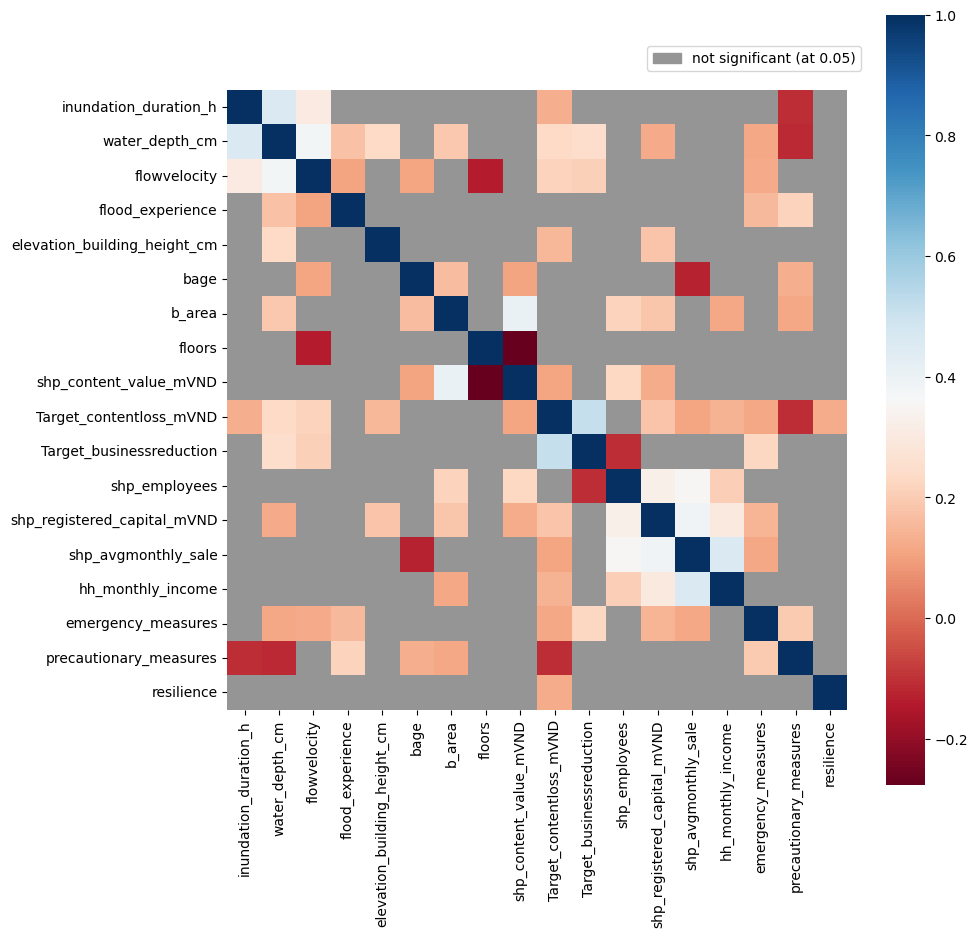

In [1090]:
plt.figure(figsize=(10,10))

import utils.utils_figures as f
f.plot_spearman_rank(all_input, min_periods=50, signif=True, psig=0.05)

## Unify monetary values

In [1091]:
## check for very small registered capital
vars_money = all_input.filter(regex="_mVND", axis=1)
vars_money[vars_money.shp_registered_capital_mVND <=1.0]  # less than 40 euros


,shp_content_value_mVND,Target_contentloss_mVND,shp_registered_capital_mVND
4,900.0,0.0,1.0
137,150.0,0.0,1.0
214,150.0,0.0,1.0


*list of all monetary vars*

- b_value_mVND	- price level for 2020 (year when survey was done)
- shp_building_value_mVND	- price level for 2020
- shp_content_value_mVND	- price level for 2020
- Target_contentloss_mVND	- price levels based on flood time
- shp_registered_capital_mVND  - price level for 2020
- hh_monthly_income_cat     - categorical [value ranges in mVND], # price level for 2020
- shp_avgmonthly_sale_cat   - categorical [value ranges in mVND], # price level for 2020

keep categorical monetary variables unchanged (hh_monthly_income_cat, shp_avgmonthly_sale_cat) [in mVND]
All other vars are inflation corrected based on flood time or when survey was done 
cpi_2020 = 168.8    ,  2020 = year when the survey was done



In [1092]:
## covnert all columns with million VND to VND

vars_money = np.where( (vars_money.values != np.nan),
            vars_money.values * 1000000, # convert to VND
            vars_money.values)

## rename columns
new_cols = all_input.filter(regex="_mVND", axis=1).columns.str.replace("_mVND", "_VND")
vars_money = pd.DataFrame(vars_money, columns=new_cols)


*Conversion of VND to euro (or US$)*

Based on JRC, p.8 and Paprotny2018, eg.p245
The reported damage values have been converted to Euro using the the exchange rate for the year 2020 (mean annual value)

*Source:* 
- www.oanda.com/currency/historical-rates
-  www.ecb.europa.eu/stats/exchange/eurofxref/html/eurofxref-graph-idr.en.html


In [1093]:
price_index_year_of_issue = {
    2011: 121.41,
    2012: 132.44,
    2013: 137.78,
    2014: 142.88,
    2015: 140.43,
    2016: 142.98,
    2017: 149.22,
    2018: 154.63,
    2019: 158.38,
    2020: 160.70
}

price_index_2020 = 160.70
price_index_year = data_ip2["flood_year"].astype("Int64").map(price_index_year_of_issue)  # series of cpi for each year of flood event

exchange_rate = 1 / 27155  #  dong-> euro in 2020 
## (based on eurostat: https://ec.europa.eu/eurostat/databrowser/view/ERT_BIL_EUR_A/default/line?lang=en )

*Inflation correction via GDP-deflator*


\begin{equation}
\begin{align*}

&uninflated_{2020} = losses_y * exchangerate_{2020} \\
&inflationrate = uninflated_{2020} * pindex_{2020} / pindex_y\\

\end{align*}
\end{equation}

where:
- losses_y : losses in VND for year y
- uninflated_{2020} : uninflated losses in euro for 2020
- exchangerate_{2020} : exchang erate for VND to euro in year 20202 
- pindex_{2020} : price index from GDP-deflator for 2020 
- pindex_y : price index from GDP-deflator in year y

Given that inflation is the percentage change in the overall price of an item in an economy, we can use the GDP deflator to calculate the inflation rate since its a measure of the price level.


*Further sources*
Paprotny 2018: also used country-level GDP deflators for adjusting nomnal to real losses in 2011 prices , p153, p244
Sairam et al. 2020


In [1094]:
#vars_money[c].apply(pd.to_numeric)#.isna()


In [1095]:
## GDP-deflator

vars_money["Target_contentloss_VND_gdp"] = None

##  only direct losses needs inflation correction in respect to flood time
for r in range(len(vars_money.Target_contentloss_VND)):
    ## exchange rate: convert VND in certain year to € in the same year
    uninflated_losses = (vars_money.Target_contentloss_VND[r] * exchange_rate) # get uninflated losses in euros for year 2020
    ## price index from GDP-deflator
    vars_money["Target_contentloss_VND_gdp"][r] = round(uninflated_losses * price_index_2020 / price_index_year[r], 1)



# ##  for all other monetary continous vars: only need exchange conversion
for c in vars_money.drop(["Target_contentloss_VND_gdp","Target_contentloss_VND"], axis=1).columns:
    vars_money[c] = vars_money[c].apply(pd.to_numeric)
    for r in range(len(vars_money[c])):
        ## convert VND_2020 to €_2020
        vars_money[c][r] = round((vars_money[c][r] * exchange_rate), 1)#.astype(int)


## rename columns
new_cols = vars_money.filter(regex="_VND", axis=1).columns.str.replace("_VND", "_euro")
vars_money.columns = new_cols



In [1096]:
# update all_input with unified and inflated currencies
all_input.drop(all_input.filter(regex="_mVND", axis=1).columns, axis=1, inplace=True) 
all_input = pd.concat([all_input, vars_money], axis=1)
all_input.filter(regex="euro", axis=1).columns


Index(['shp_content_value_euro', 'Target_contentloss_euro',
       'shp_registered_capital_euro', 'Target_contentloss_euro_gdp'],
      dtype='object')

## Create single datasets for each response
Select candiate predictors in respect to the response variables: Split dataset into two parts, one with candidate predictors for content losses and one dataset with candidate predictors for business reduction. This means non relevant candidate predictors fo the respective response are moved.

In [1097]:
all_input.drop("Target_contentloss_euro", axis=1, inplace=True)
all_input = all_input.rename(columns={"Target_contentloss_euro_gdp": "Target_contentloss_euro"})

In [1098]:
all_input_contentloss = all_input
all_input_contentloss = all_input_contentloss.drop(
    [
    "Target_businessreduction",
    #"shp_suppliers",  # rm due that no reasnable link to contelt losses (<-> compare Business reduction)
    #"perception_who_responsible4protection*",
    "floors", # used to derive shp_content_value and relative_content_loss
    ]
    , axis=1)
print(all_input_contentloss.shape)
all_input_contentloss.columns



(393, 16)


Index(['inundation_duration_h', 'water_depth_cm', 'flowvelocity',
       'flood_experience', 'elevation_building_height_cm', 'bage', 'b_area',
       'shp_employees', 'shp_avgmonthly_sale', 'hh_monthly_income',
       'emergency_measures', 'precautionary_measures', 'resilience',
       'shp_content_value_euro', 'shp_registered_capital_euro',
       'Target_contentloss_euro'],
      dtype='object')

In [1099]:
all_input_business_reduction = all_input
all_input_business_reduction = all_input_business_reduction.drop(
    [
    "Target_contentloss_euro",
    #"shp_content_value_euro", ## content value can infleunce busines reduction eg. heavy and expensive machinery
        "floors", # used to derive shp_content_value and relative_content_loss
    # "buildingtype_moon"  # remove due to 64 % missing values
    # "perception_private_economy_future"
    # #"perception_who_responsible4protection*",
    # "resilience_govern_warnings_helpful",
    # "resilience_more_future_affected",
    # #"resilience_govern_careing"
    ],
    axis=1)
print(all_input_business_reduction.shape)
all_input_business_reduction.columns

(393, 16)


Index(['inundation_duration_h', 'water_depth_cm', 'flowvelocity',
       'flood_experience', 'elevation_building_height_cm', 'bage', 'b_area',
       'Target_businessreduction', 'shp_employees', 'shp_avgmonthly_sale',
       'hh_monthly_income', 'emergency_measures', 'precautionary_measures',
       'resilience', 'shp_content_value_euro', 'shp_registered_capital_euro'],
      dtype='object')

In [1100]:
## get corr beween CV derived from fixed floor number or DLR based floor number
# Pearson corr: with DLR floor number : 0.76	, fixed floor number  : 0.67
# slightly higher spearman corr for Cv based on fixed number of floors (0.11) vs DLR floors (0.06)

#all_input_contentloss[["Target_contentloss_euro", "shp_content_value_euro"]].corr(method="pearson")
all_input_contentloss[["Target_contentloss_euro", "shp_content_value_euro"]].corr(method="spearman")
## --> huge difference between person and speamrn corr: due to skewed data or outliers, and that outliers are leading Pearso

,Target_contentloss_euro,shp_content_value_euro
Target_contentloss_euro,1.0,0.1
shp_content_value_euro,0.1,1.0


(0.0, 1000.0)

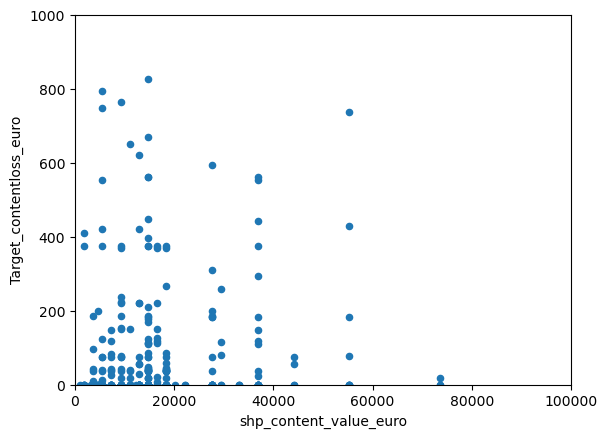

In [1101]:
all_input_contentloss.plot.scatter("shp_content_value_euro", "Target_contentloss_euro")
plt.xlim(0, 100000)
plt.ylim(0, 1000)


### relative content loss
Content loss dataset: create new Target for relative content loss
Derive relative content loss in ratio to the estimated content value of each business

In [1102]:
all_input_contentloss["Target_contentloss_euro"] = all_input_contentloss["Target_contentloss_euro"].apply(pd.to_numeric)

all_input_contentloss["Target_relative_contentloss_euro"] =  all_input_contentloss["Target_contentloss_euro"] / all_input_contentloss["shp_content_value_euro"]
#all_input_contentloss["Target_relative_contentloss_euro"].describe()
all_input_contentloss = all_input_contentloss.drop(["shp_content_value_euro", "Target_contentloss_euro"], axis=1)

Set relative losses which excede content value to 1, indicating relativ losses as high as the entire content value of the business

In [1103]:
print("Records with relative content loss exceding the content values for businesses:", sum(all_input_contentloss.Target_relative_contentloss_euro >1.0) )

all_input_contentloss.Target_relative_contentloss_euro[all_input_contentloss.Target_relative_contentloss_euro > 1.0]  = 1.0
#print(all_input_contentloss[all_input_contentloss.Target_relative_contentloss_euro > 0.99 ])

Records with relative content loss exceding the content values for businesses: 2


### Uncertainty of geolocations

In [1104]:
# df["geometry"][1].is_
# " ".join([is_digit()])

In [1105]:
# geo_df = gpd.GeoDataFrame(df,  
#             geometry=gpd.points_from_xy( 
#                     df["geometry"].str.split(",").str[1], # lon
#                     df["geometry"].str.split(",").str[0],  # lat
#             )
#         )

In [1106]:
# glimpse = df[df.shp_employees >= 10]
# glimpse.geometry.explore() 

# ## visual check of SMEs locations
# import folium

# glimpse = raw_data_vietnamese[~ raw_data_vietnamese.is_empty]   # drop emtpy geoms
# glimpse_geolocations = geoinformations[~ geoinformations.is_empty]   # drop emtpy geoms
# m = glimpse.geometry.explore(name="survey ds", color="red", k=6)  
# m = glimpse_geolocations.explode(ignore_index=True).explore(
#     m=m, 
#     name="geolocations",
#     column="Nr_Floors", 
#     popup=True, 
#     #tooltip="Nr_Floors", 
#     cmap="viridis"
# )    # BT_Moon BT_TUEB_2

# folium.LayerControl().add_to(m)
# m

Geolocations from the survey of the two largest businesses was compared with their actual location done by an internet search. It could be seen that the geolocations mentioned in the survey at least for the two largest businesses ahave potentially a high uncertainty range which is at least for the two examined businesses more than 200 m (beeline). The usage of spatial variables would be highly imprecise. Furthermore deriving the content value from building height is similar imprecise.


## write to disk

In [1107]:
## move targets to beginning
all_input_contentloss.insert(0, "Target_relative_contentloss_euro", all_input_contentloss.pop("Target_relative_contentloss_euro"))
all_input_business_reduction.insert(0, "Target_businessreduction", all_input_business_reduction.pop("Target_businessreduction"))


In [1108]:
all_input_contentloss.columns


Index(['Target_relative_contentloss_euro', 'inundation_duration_h',
       'water_depth_cm', 'flowvelocity', 'flood_experience',
       'elevation_building_height_cm', 'bage', 'b_area', 'shp_employees',
       'shp_avgmonthly_sale', 'hh_monthly_income', 'emergency_measures',
       'precautionary_measures', 'resilience', 'shp_registered_capital_euro'],
      dtype='object')

In [1109]:
all_input_business_reduction.columns
#all_input_business_reduction.precautionary_measures.value_counts()

Index(['Target_businessreduction', 'inundation_duration_h', 'water_depth_cm',
       'flowvelocity', 'flood_experience', 'elevation_building_height_cm',
       'bage', 'b_area', 'shp_employees', 'shp_avgmonthly_sale',
       'hh_monthly_income', 'emergency_measures', 'precautionary_measures',
       'resilience', 'shp_content_value_euro', 'shp_registered_capital_euro'],
      dtype='object')

In [1110]:
## save to disk
all_input_contentloss.to_excel("../input_survey_data/input_data_contentloss_tueb.xlsx", index=False)
all_input_business_reduction.to_excel("../input_survey_data/input_data_businessreduction_tueb.xlsx", index=False)

In [ ]:
print("Relative content loss dataset")
print("Number of candidate predictors ", all_input_contentloss.shape[1])
print("Number of cases ", all_input_contentloss.shape[0])

print("\nBusiness reduction dataset")
print("Number of candidate predictors ", all_input_business_reduction.shape[1])
print("Number of cases ", all_input_business_reduction.shape[0])

Relative content loss dataset
Number of candidate predictors  16
Number of cases  393

Business reduction dataset
Number of candidate predictors  17
Number of cases  393


In [855]:
## export distribution statistics 

pd.set_option('display.float_format', lambda x: '%.1f' % x)
tbl = all_input.describe().T
tbl.to_excel("../input_survey_data/input_data_business_distrib_tueb.xlsx", index=True)
tbl.tail(10)

,count,mean,std,min,25%,50%,75%,max
Target_businessreduction,393.0,17.6,24.1,0.0,0.0,10.0,30.0,100.0
shp_employees,393.0,1.9,2.0,1.0,1.0,2.0,2.0,34.0
shp_avgmonthly_sale,393.0,10.3,12.3,2.5,2.5,7.5,7.5,75.0
hh_monthly_income,393.0,11.7,10.9,0.0,8.0,8.0,15.0,90.0
emergency_measures,393.0,0.4,0.3,0.0,0.2,0.3,0.5,1.0
precautionarymeasures_lowcost,393.0,0.3,0.2,0.0,0.2,0.2,0.4,0.8
precautionary_measures_expensive,393.0,0.2,0.3,0.0,0.0,0.0,0.5,1.0
resilience,393.0,3.0,0.5,1.7,2.7,3.0,3.4,4.4
shp_content_value_euro,393.0,17744.0,18072.6,1104.8,9206.4,14730.3,18412.8,202541.0
shp_registered_capital_euro,393.0,4894.5,36529.6,36.8,368.3,1104.8,1841.3,699687.0
